## Introduction

Stan solution to [nested_model_example.ipynb](nested_model_example.ipynb).


In [1]:
# set up Python
import re
import json
import inspect
import logging
import numpy as np
import pandas as pd
from IPython.display import Markdown
import plotnine
from plotnine import *

from nested_model_fns import (
    define_Stan_model_with_forecast_period,
    solve_forecast_by_Stan,
    plot_forecast,
    extract_sframe_result,
    plot_decomposition,
    plot_model_quality,
    plot_model_quality_by_prefix,
    plot_params,
    plot_past_and_future,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
with open("generating_params.json", "r") as file:
    generating_params = json.load(file)
modeling_lags = generating_params["generating_lags"]
b_z = generating_params["b_z"]
b_x = generating_params["b_x"]

generating_params

{'b_auto_0': 1.2804125781056719,
 'b_imp_0': 10.4,
 'b_auto': [1.9753766811902755, -1],
 'b_z': [14.2],
 'b_x': [16.1],
 'generating_lags': [1, 2],
 'modeling_lags': [1, 2]}

In [3]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

## Solving again with the Bayesian "big hammer"


We now try a Bayesian model with the correct generative structure, using the [Stan](https://mc-stan.org/users/interfaces/cmdstan) software package.


In [4]:
# define a Stan model for both transient external regressors and future predictions
stan_model_with_forecast_i, stan_model_with_forecast_src_i = (
    define_Stan_model_with_forecast_period(
        application_lags=modeling_lags,
        n_transient_external_regressors=len(b_x),
        n_durable_external_regressors=len(b_z),
    )
)

In [5]:
# show the model specification
print(stan_model_with_forecast_src_i)


data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector<lower=0>[N_y_observed] y_observed;   // observed outcomes
  vector[N_y_observed + N_y_future] x_imp_1;  // observed transient external regressor
  vector[N_y_observed + N_y_future] x_dur_1;  // observed durable external regressor
}
parameters {
  real b_auto_0;                      // auto-regress intercept
  real b_imp_0;                       // total/impulse/transient intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector[1] b_x_imp;                          // transient external regressor coefficients
  vector[1] b_x_dur;                          // durable external regressor coefficients
  vector<lower=0>[N_y_future] y_future;                // to be inferred future state
  vector<lower=0>[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  re

`y` and `y_auto` are supposed to be non-negative (a constraint we have chosen to *not* enforce, as it degraded results, probably by damaging sampling paths).

Please keep in mind a distributional statement such as <code>y ~ normal(f(y_auto, x), &sigma;)</code> is actually modeling the residual <code>(y - f(y_auto, x))</code> as being distributed <code>normal(0, &sigma;)</code>. So the above model-block statements are distributional assumptions about *residuals*, as the intended mean is an input to these statements. Thus we are specifying a normal distribution for residuals, not a normal distribution for expected values or predictions. I feel the normal approximation for `y`'s residual is not that bad. A similar statement can be made for `y_auto`'s residuals.

All in all: specifying systems to Stan is a compromise in respecting problem structure, and preserving the ability to effectively sample. The specification tends to requires some compromise and experimentation. In my opinion, it isn't quite the case that "Bayes' Law names only one legitimate inferential network and we can then use that one!" One is going to have to specify an approximate system. It becomes the user's responsibility to design for a (hopefully) high utility tradeoff between fidelity and realizability.

We obviously will not know all the priors. So we hope the problem is somewhat insensitive to them and just set them to not so bad distributions. It is possible to over-worry on priors, and somewhat freeing to just think of them as [regularizations](https://en.wikipedia.org/wiki/Regularization_(mathematics)) or biases for the values in question to be small. Also it sometimes makes sense to fight symmetries or degeneracies in the specification by adding "complementarity" constraints such as `b_auto_0 * b_imp_0 ~ normal(0, 0.1)`. This is not a distributional claim we believe, but a trick in saying we expect the product to be small to enforce we expect only one of the two values to be non-negligible. Again, think of the model distributional claims as "criticisms" and not if they are prior (before seeing data) or posterior (after seeing data) opinions. Also, don't be profligate with these exotic checks: they break convexity of the function we are optimizing and can make sampling harder.


What Stan generates is: thousands of possible trajectories of parameters, and past and future hidden state.


In [6]:
# sample from Stan model solutions
forecast_soln_i = solve_forecast_by_Stan(
    model=stan_model_with_forecast_i,
    d_train=d_train,
    d_apply=d_test,
    durable_external_regressors=["z_0"],
    transient_external_regressors=["x_0"],
)

forecast_soln_i  # see https://mc-stan.org/docs/cmdstan-guide/stansummary.html

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_0,b_imp_0,b_auto[0],...,y[990],y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999]
0,2751.66,0.984557,0.000681,10.0,1023.0,0.0,-2246.98,1.72548,5.527660,1.93461,...,119.1740,138.951,127.5430,130.8020,134.1020,131.5900,145.020,141.5730,135.0020,114.8510
1,2671.88,0.716410,0.000681,10.0,1023.0,0.0,-2207.91,1.67196,5.631520,1.94201,...,119.4980,139.299,123.8590,125.5530,127.3430,126.2070,140.113,137.4690,130.8650,103.5390
2,2685.48,0.711159,0.000681,10.0,1023.0,0.0,-2117.03,1.77024,5.442450,1.93667,...,117.0000,137.611,122.7140,124.5230,124.9800,125.3850,139.300,133.7320,128.6200,106.7970
3,2660.62,0.831234,0.000681,10.0,1023.0,0.0,-2153.89,1.76026,5.478450,1.93791,...,122.0440,141.890,127.3360,128.9840,127.1980,125.8770,137.868,133.2000,125.4540,101.7380
4,2688.26,0.993651,0.000681,10.0,1023.0,0.0,-2187.12,1.60240,5.436350,1.93338,...,118.2820,135.129,118.2260,117.7010,116.3820,112.1160,126.185,122.2060,120.3850,96.7930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2889.75,0.580267,0.000460,10.0,1023.0,0.0,-2388.57,1.74449,0.501399,1.94419,...,84.6437,102.039,90.9413,93.1846,94.8948,94.7707,106.333,102.7110,99.5626,76.4891
3996,2847.28,0.781886,0.000460,10.0,1023.0,0.0,-2352.80,1.98064,0.280304,1.92382,...,88.1289,105.433,91.7402,93.8557,92.1376,87.9054,100.764,97.5132,96.5882,76.4921
3997,2881.87,0.967291,0.000460,10.0,1023.0,0.0,-2350.38,1.71412,0.539080,1.94138,...,91.1935,111.739,97.2521,98.3444,96.9958,94.6338,107.469,102.6240,95.4800,74.7049
3998,2912.67,0.952799,0.000460,10.0,1023.0,0.0,-2385.93,1.73686,0.293807,1.93997,...,87.9939,107.506,93.7394,91.8383,89.3006,88.8119,101.146,96.2535,94.7297,77.8300


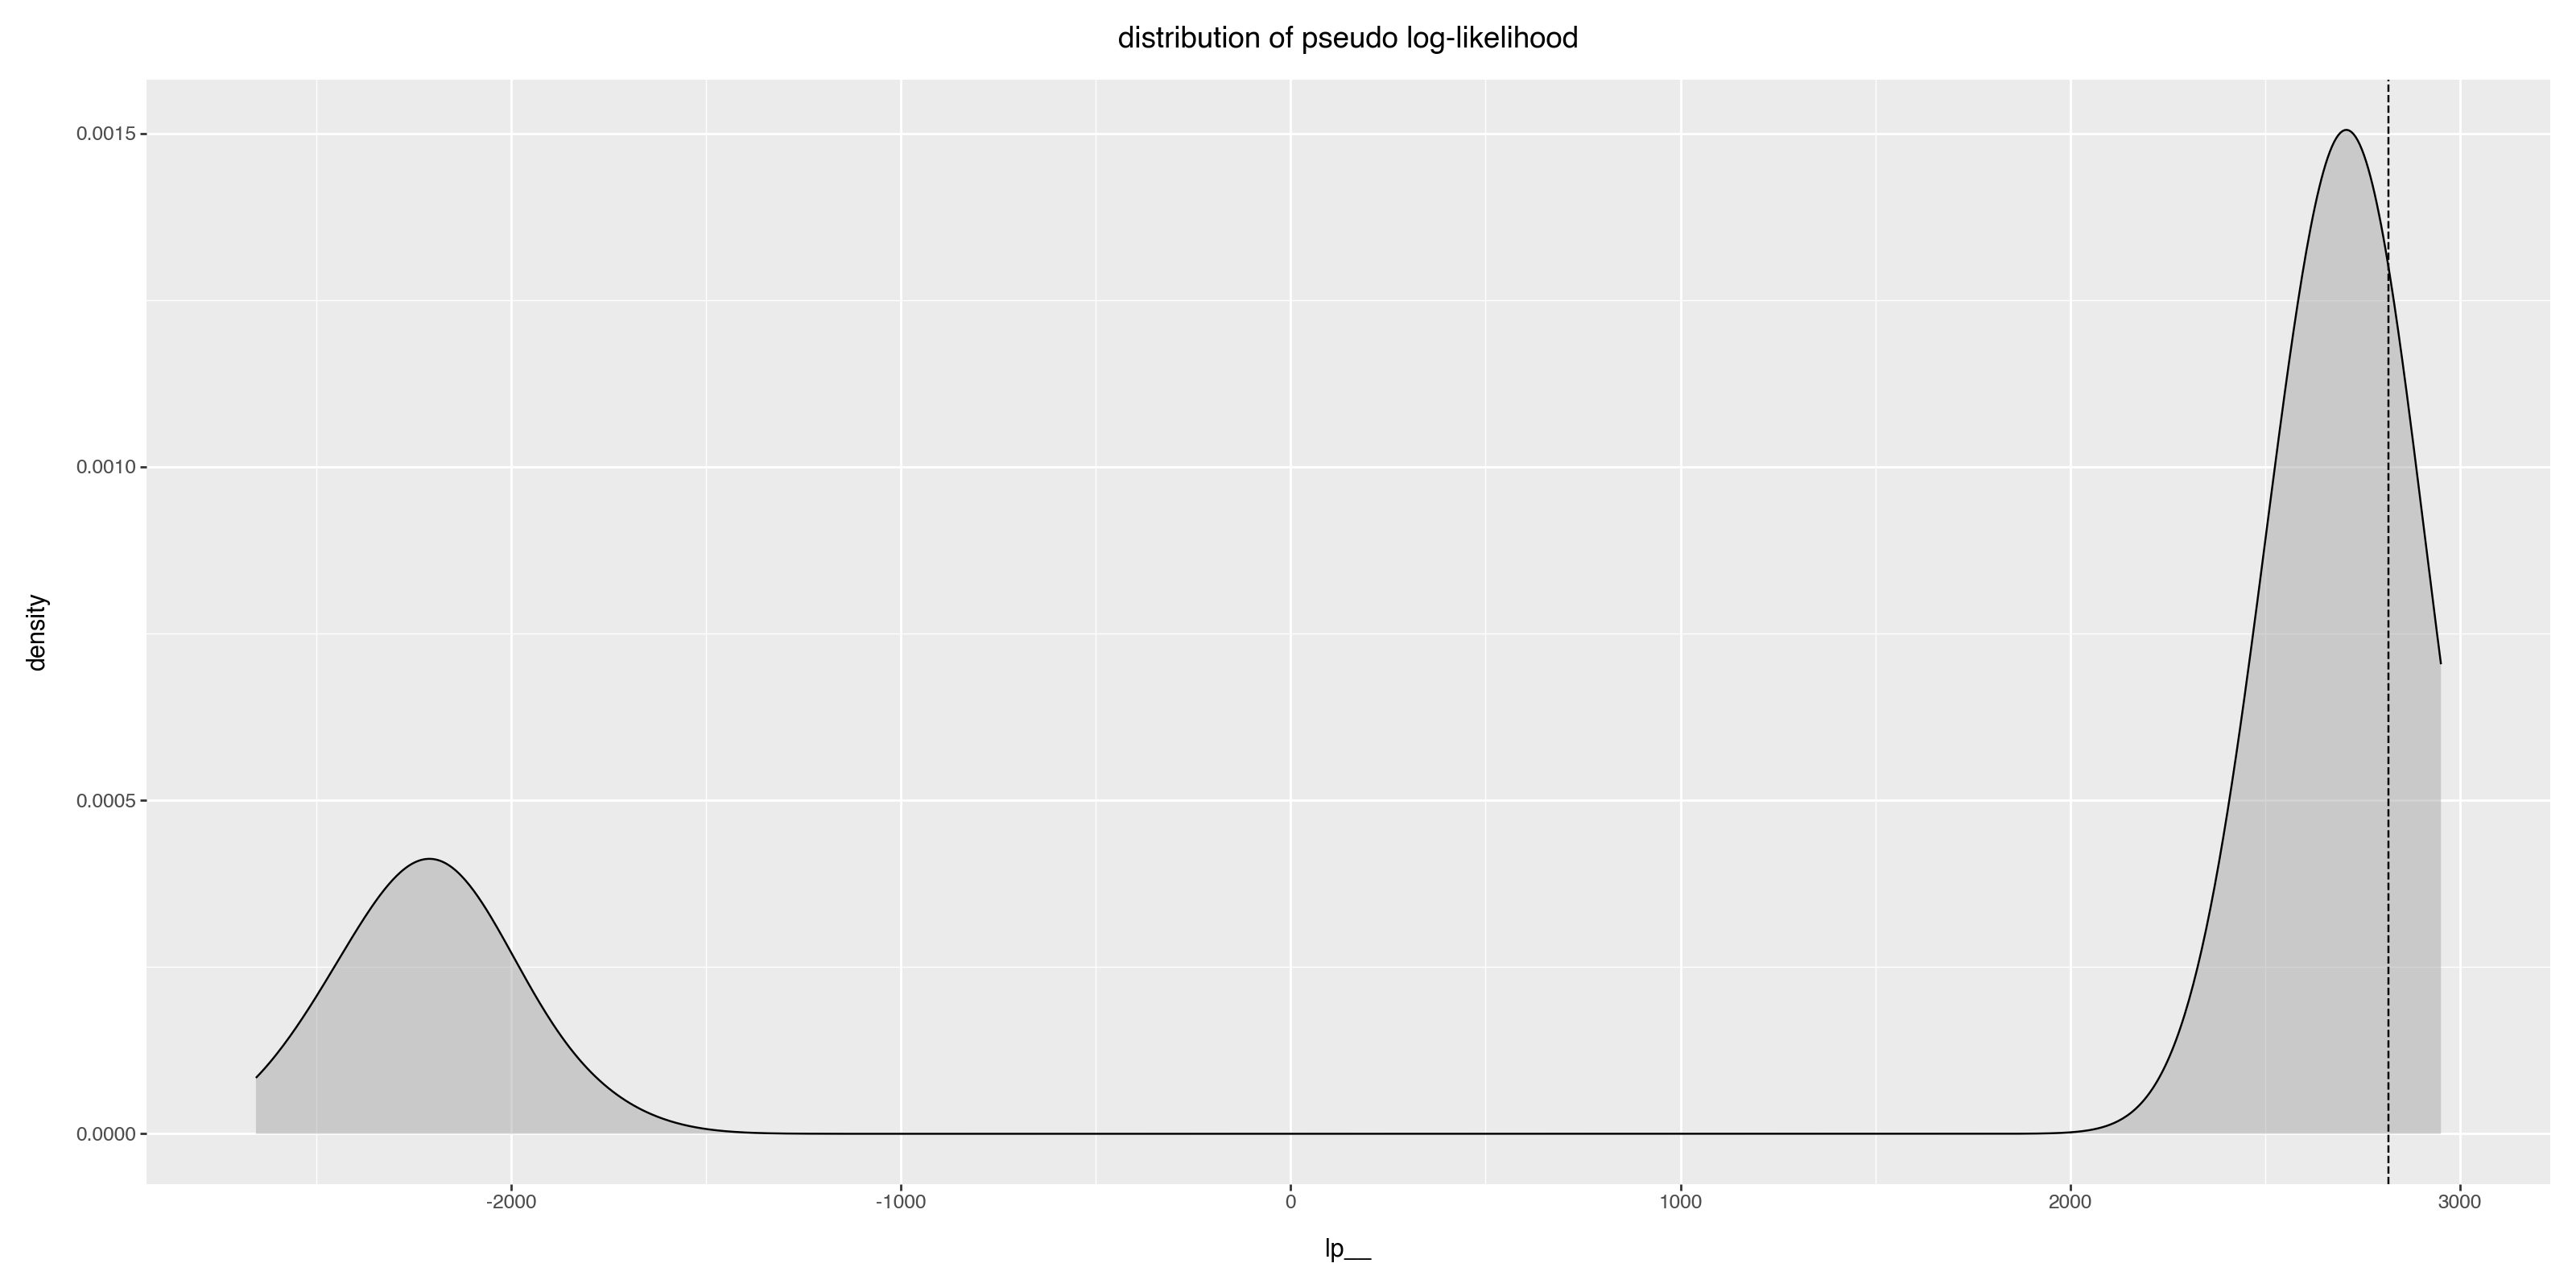

In [7]:
lp__q_90 = forecast_soln_i['lp__'].quantile(q=0.9)
(
    ggplot(
        data=forecast_soln_i,
        mapping=aes(x='lp__')
    )
    + geom_density(fill="darkgrey", alpha=0.5)
    + geom_vline(xintercept=lp__q_90, linetype="dashed")
    + ggtitle("distribution of pseudo log-likelihood")
)

`lp__` is a shifted copy of the log-likelihood. We expect in most situations the distribution of `lp__` will be unimodal and to have a standard deviation not larger than `k log(n_samples)` for some small integer `k`. The first point is fairly technical and can be related to how fast volumes grow in large dimension (similar ideas include [the asymptotic equipartition theorem](https://en.wikipedia.org/wiki/Asymptotic_equipartition_property), [the law of the iterated logarithm](https://en.wikipedia.org/wiki/Law_of_the_iterated_logarithm)). The second part is simpler: with only `n_samples` we don't expect to often see events much rarer than `1/n_samples`, so if we trajectories with log-likelihood `lp__ + c` then we shouldn't see a lot of trajectories with log-likelihood `lp__ + c - k * log(n_samples)`.  So when we do see multimodality and/or wide dispersions of `lp__`, we do have a pathology. This is one of our motivations in filtering to more likely samples, in addition to these samples representing better fits.

In [8]:
# a trick I like: limit down to the more plausible samples/trajectories
forecast_soln_i = (
    forecast_soln_i.loc[
        forecast_soln_i['lp__'] >= lp__q_90,
        :
    ].reset_index(drop=True, inplace=False)
)

We can look at a summary of the parameter estimates.


In [9]:
# summarize parameter estimates
soln_params_i = forecast_soln_i.loc[
    :, [c for c in forecast_soln_i if c.startswith("b_")]
].median()

soln_params_i

b_auto_0         1.806880
b_imp_0          1.347455
b_auto[0]        1.937960
b_auto[1]       -0.965950
b_x_imp[0]      16.027250
b_x_dur[0]      13.597500
b_var_y_auto     1.091230
b_var_y          1.017580
dtype: float64

In [10]:
# show original generative parameters
generating_params

{'b_auto_0': 1.2804125781056719,
 'b_imp_0': 10.4,
 'b_auto': [1.9753766811902755, -1],
 'b_z': [14.2],
 'b_x': [16.1],
 'generating_lags': [1, 2],
 'modeling_lags': [1, 2]}

Notice we recover `b_x_dur ~ b_z` and `b_x_imp ~ b_x` pretty well. These effect inferences can be used for planning and policy.

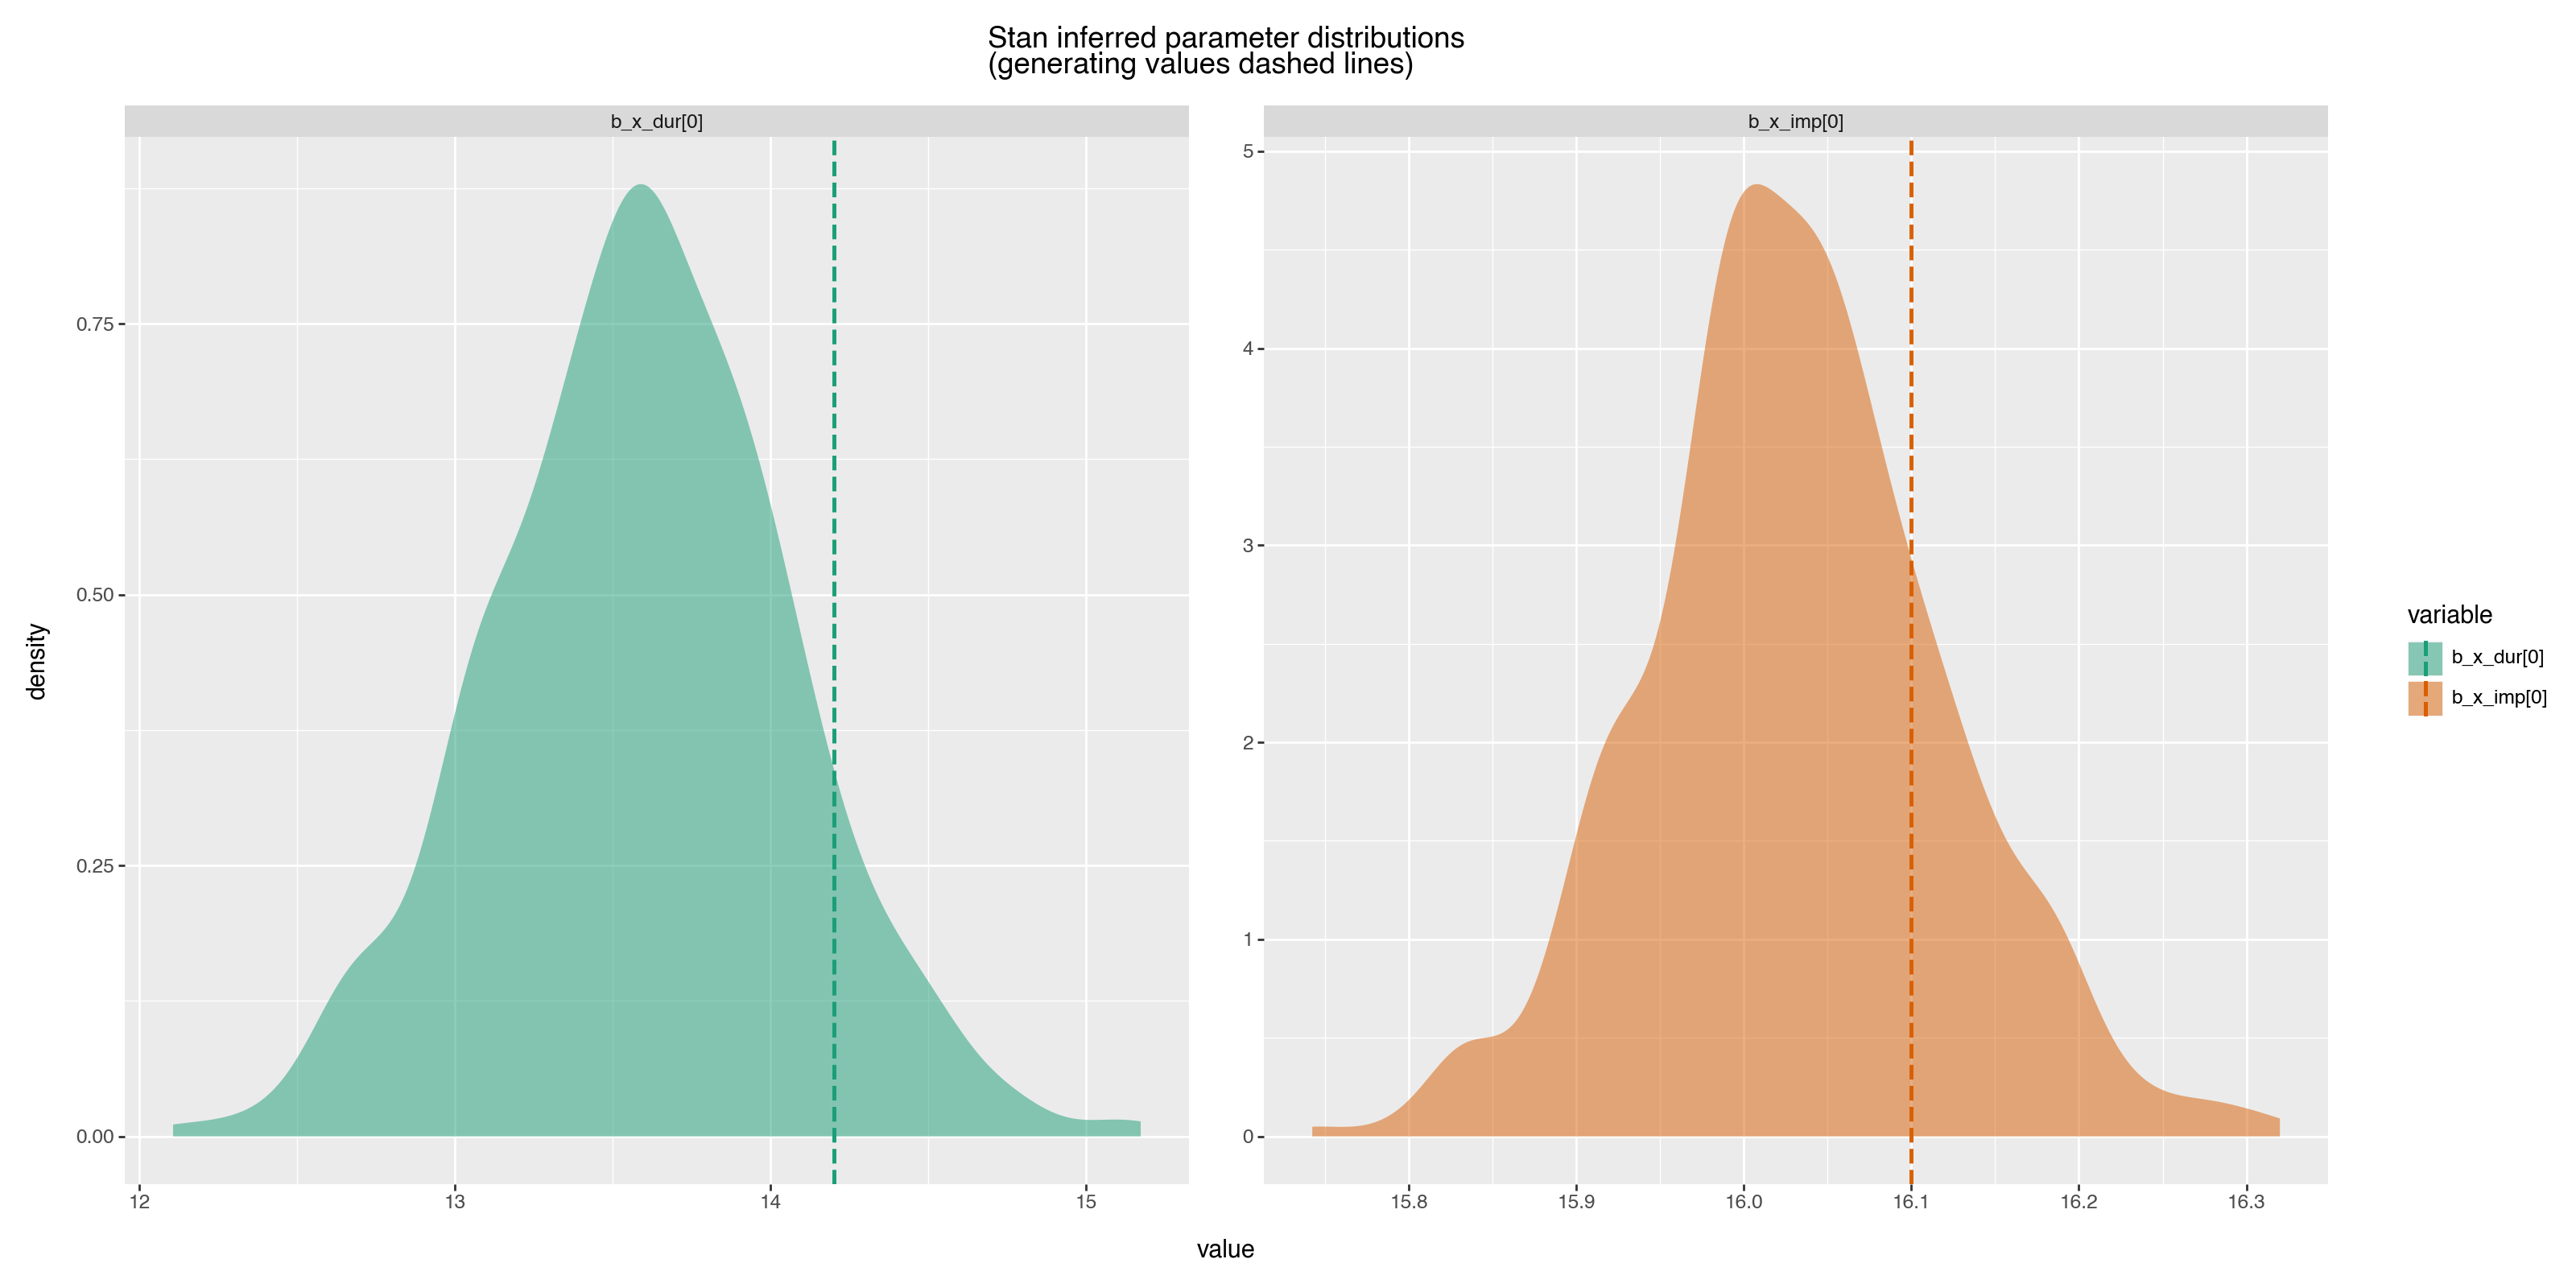

In [11]:
plot_params(
    forecast_soln_i=forecast_soln_i,
    generating_params=generating_params,
)

And we can plot both the forecasts, and *estimated* quantile bands around the estimated forecasts.


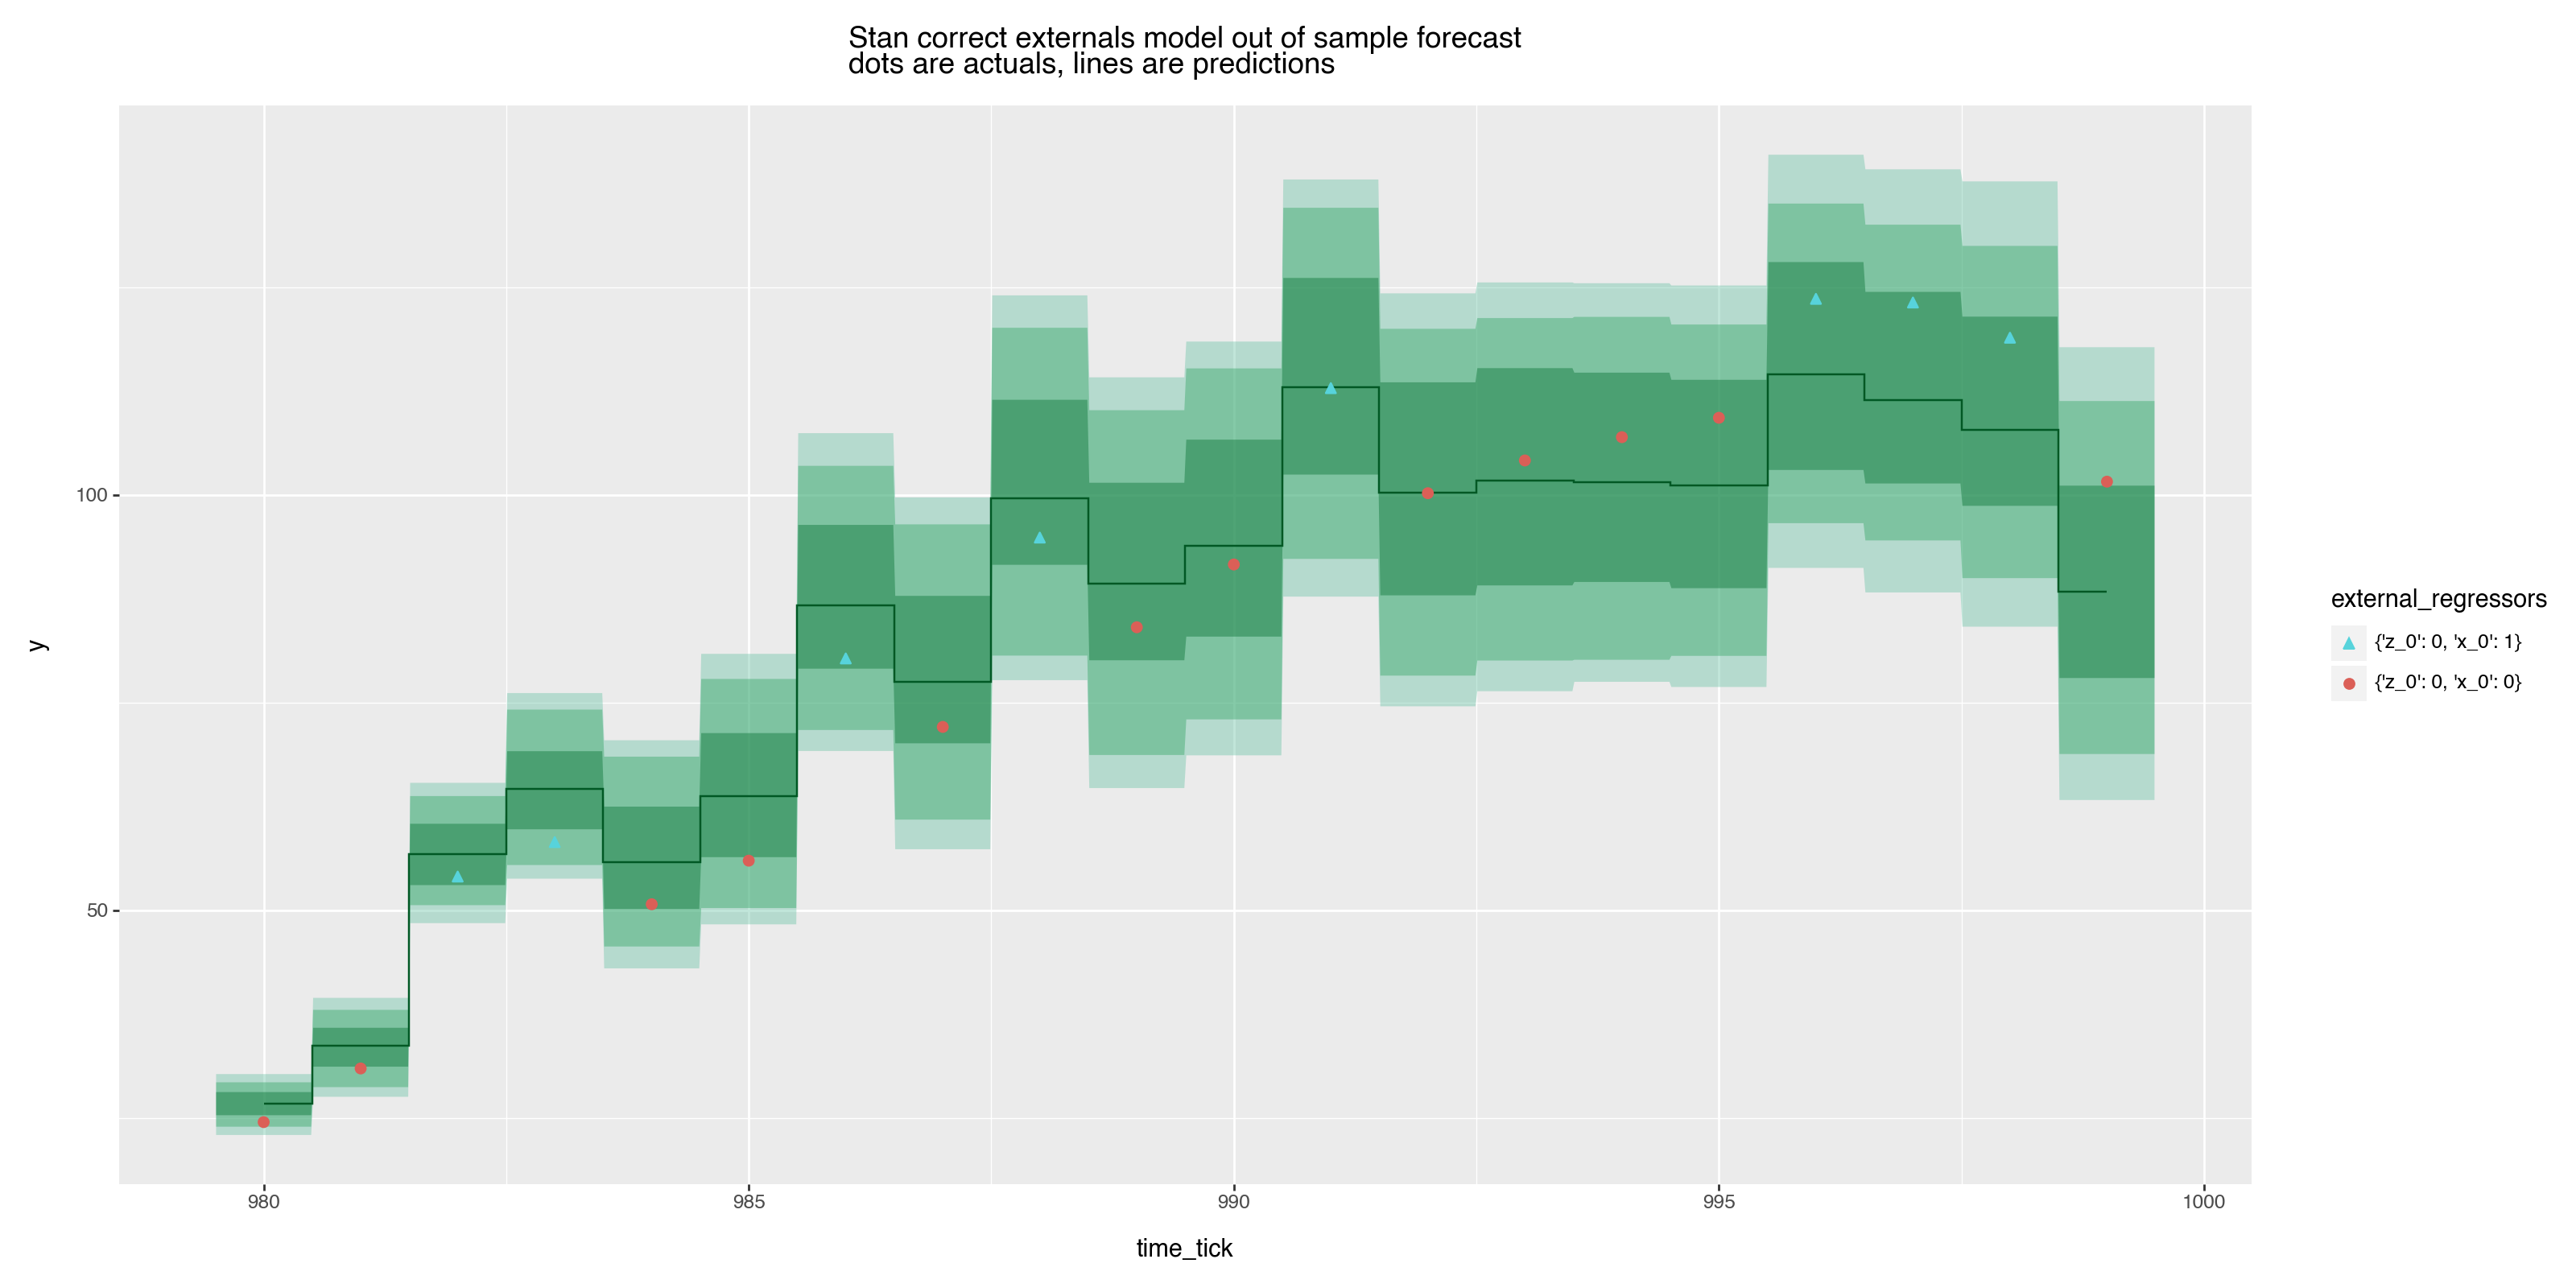

In [12]:
# plot inference over time
plt_i, s_frame_i = plot_forecast(
    forecast_soln_i,
    d_test,
    model_name="Stan correct externals model",
    external_regressors=["z_0", "x_0"],
)
plt_i.show()

In [13]:
forecast_soln_i

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_0,b_imp_0,b_auto[0],...,y[990],y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999]
0,2851.06,0.924085,0.000681,10.0,1023.0,0.0,-2341.86,1.79194,3.500800,1.93250,...,81.4059,102.544,91.2525,97.7530,102.5610,105.8980,126.207,128.4210,133.9250,120.0080
1,2836.76,0.823375,0.000681,10.0,1023.0,0.0,-2316.47,1.74836,2.724040,1.94640,...,83.7226,108.183,98.9695,101.8780,107.5980,111.3320,130.794,133.6280,132.7590,116.0170
2,2819.05,0.913753,0.000681,10.0,1023.0,0.0,-2310.24,1.83261,2.496560,1.93794,...,90.5711,114.619,105.7040,108.9890,112.9730,113.1830,129.205,126.2710,124.2150,103.3600
3,2821.94,0.992355,0.000681,10.0,1023.0,0.0,-2335.66,1.68556,2.660130,1.94469,...,82.3502,104.258,93.3199,97.9563,99.1887,104.5580,122.929,124.7420,124.1600,108.5270
4,2821.54,0.919446,0.000681,10.0,1023.0,0.0,-2305.42,1.70606,2.394990,1.94198,...,106.3860,128.527,115.2440,116.5160,117.5270,117.4570,126.238,119.2390,113.6940,91.1685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2889.75,0.580267,0.000460,10.0,1023.0,0.0,-2388.57,1.74449,0.501399,1.94419,...,84.6437,102.039,90.9413,93.1846,94.8948,94.7707,106.333,102.7110,99.5626,76.4891
396,2847.28,0.781886,0.000460,10.0,1023.0,0.0,-2352.80,1.98064,0.280304,1.92382,...,88.1289,105.433,91.7402,93.8557,92.1376,87.9054,100.764,97.5132,96.5882,76.4921
397,2881.87,0.967291,0.000460,10.0,1023.0,0.0,-2350.38,1.71412,0.539080,1.94138,...,91.1935,111.739,97.2521,98.3444,96.9958,94.6338,107.469,102.6240,95.4800,74.7049
398,2912.67,0.952799,0.000460,10.0,1023.0,0.0,-2385.93,1.73686,0.293807,1.93997,...,87.9939,107.506,93.7394,91.8383,89.3006,88.8119,101.146,96.2535,94.7297,77.8300


In [14]:
p1, p2 = plot_past_and_future(forecast_soln_i=forecast_soln_i, d_train=d_train, d_test=d_test)

/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 900 rows containing missing values.
/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 900 rows containing missing values.


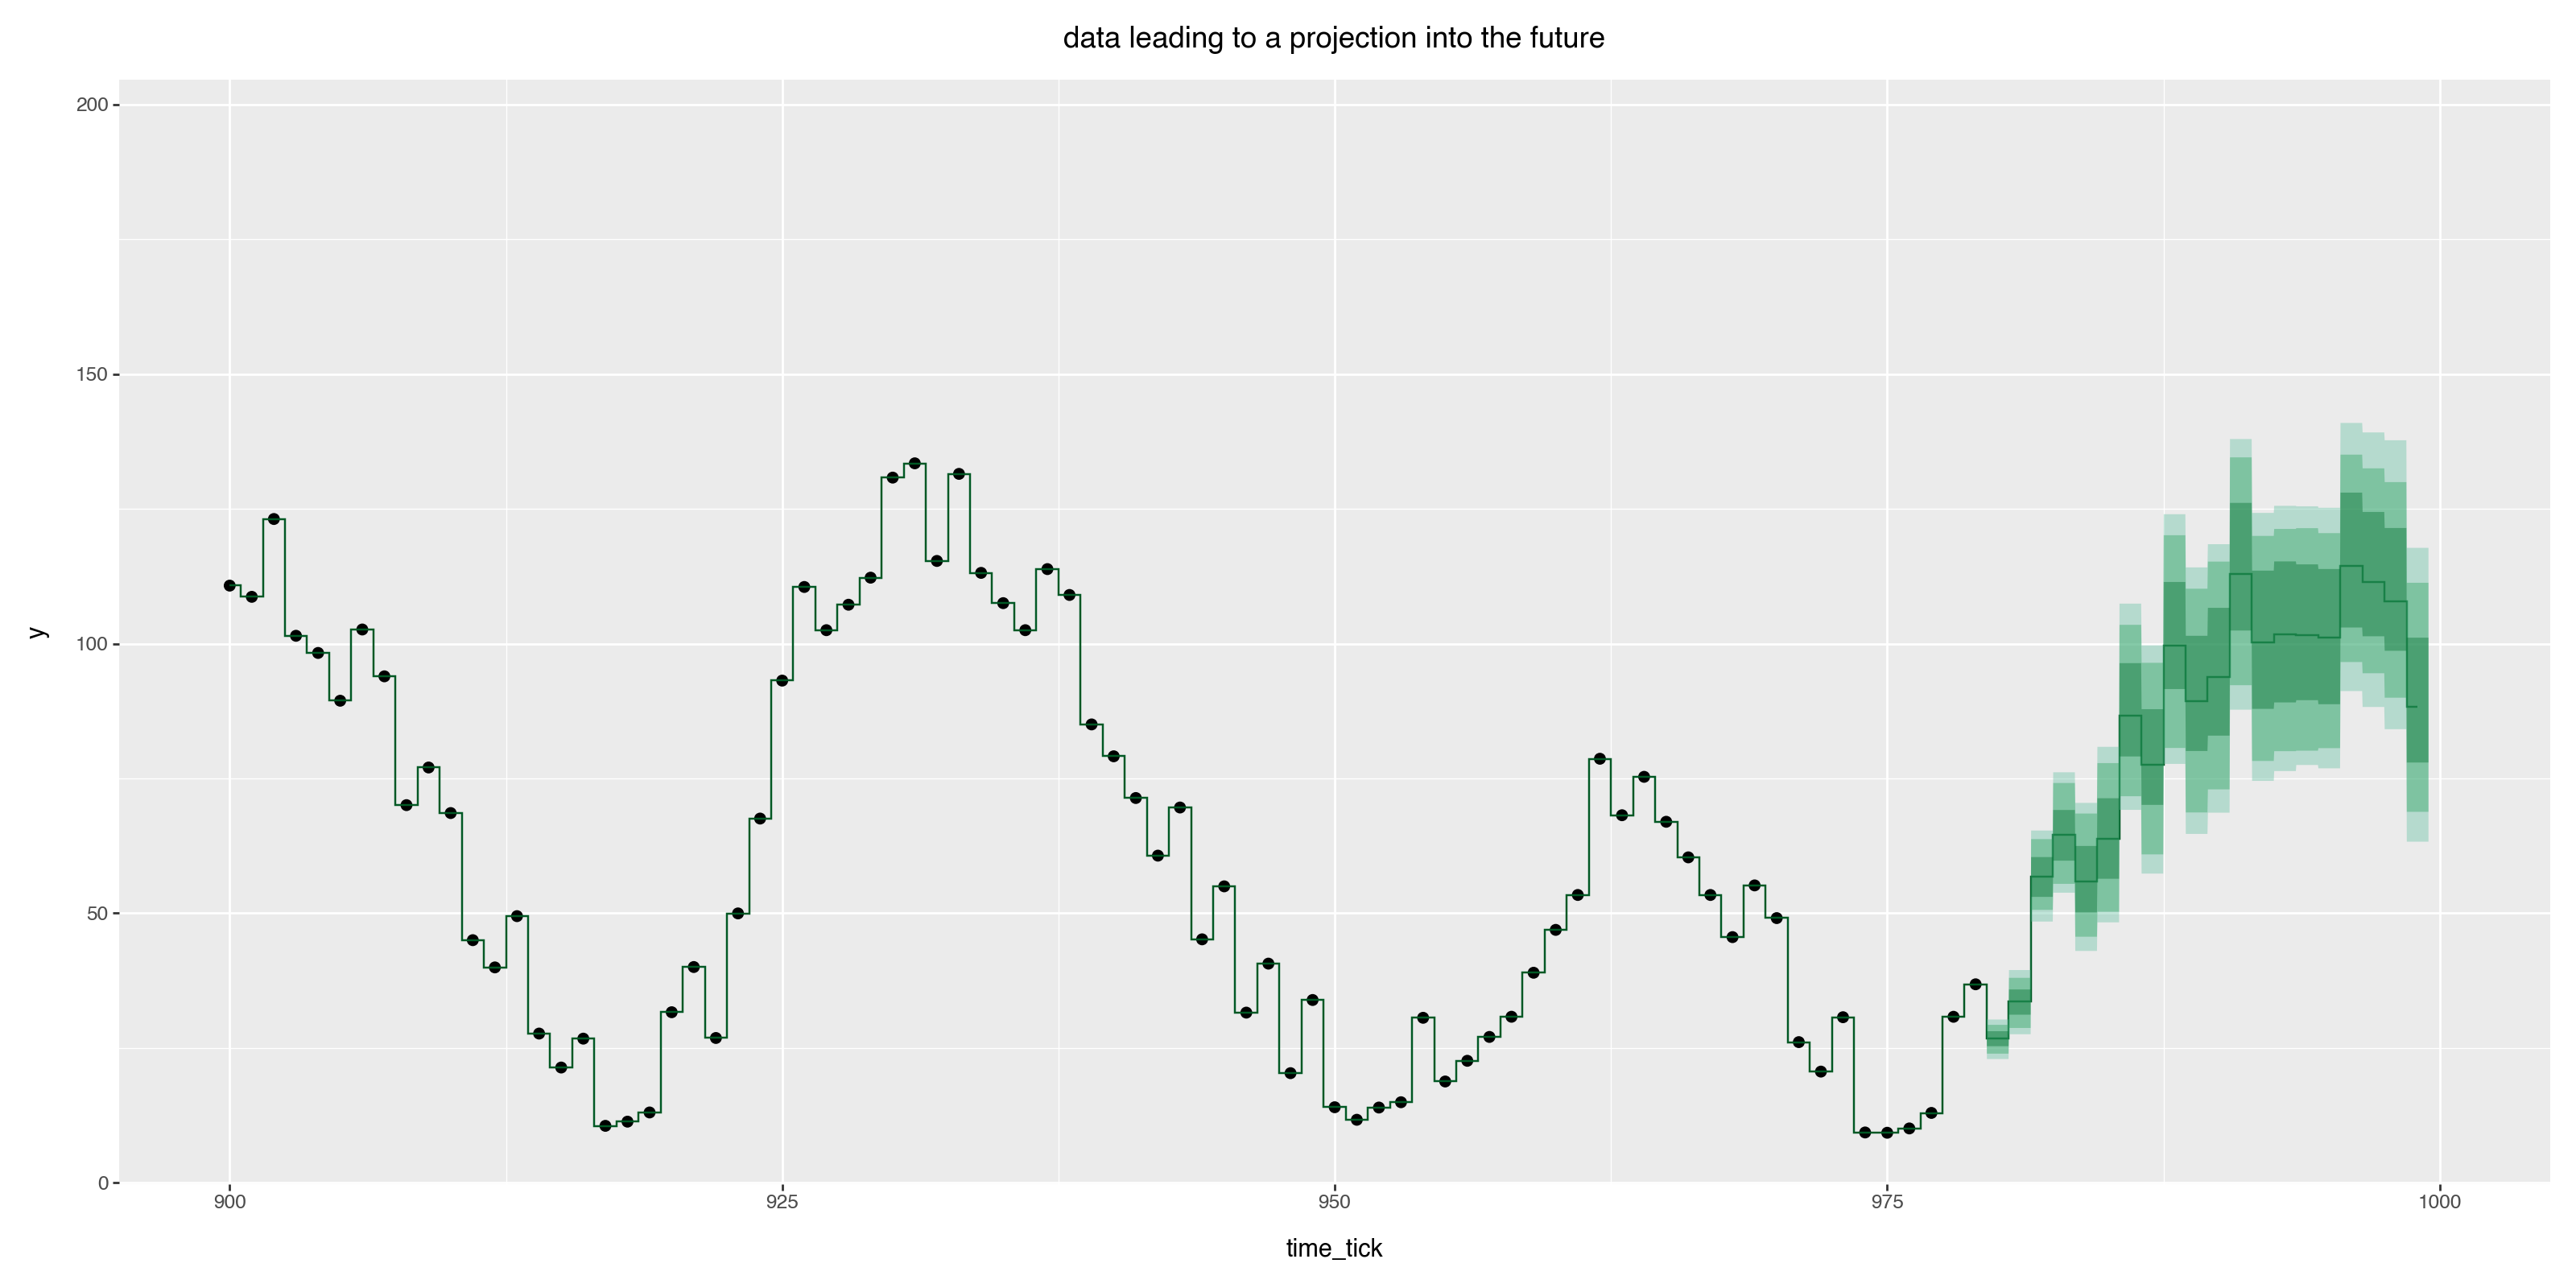

In [15]:
display(p1)

/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 900 rows containing missing values.
/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 900 rows containing missing values.


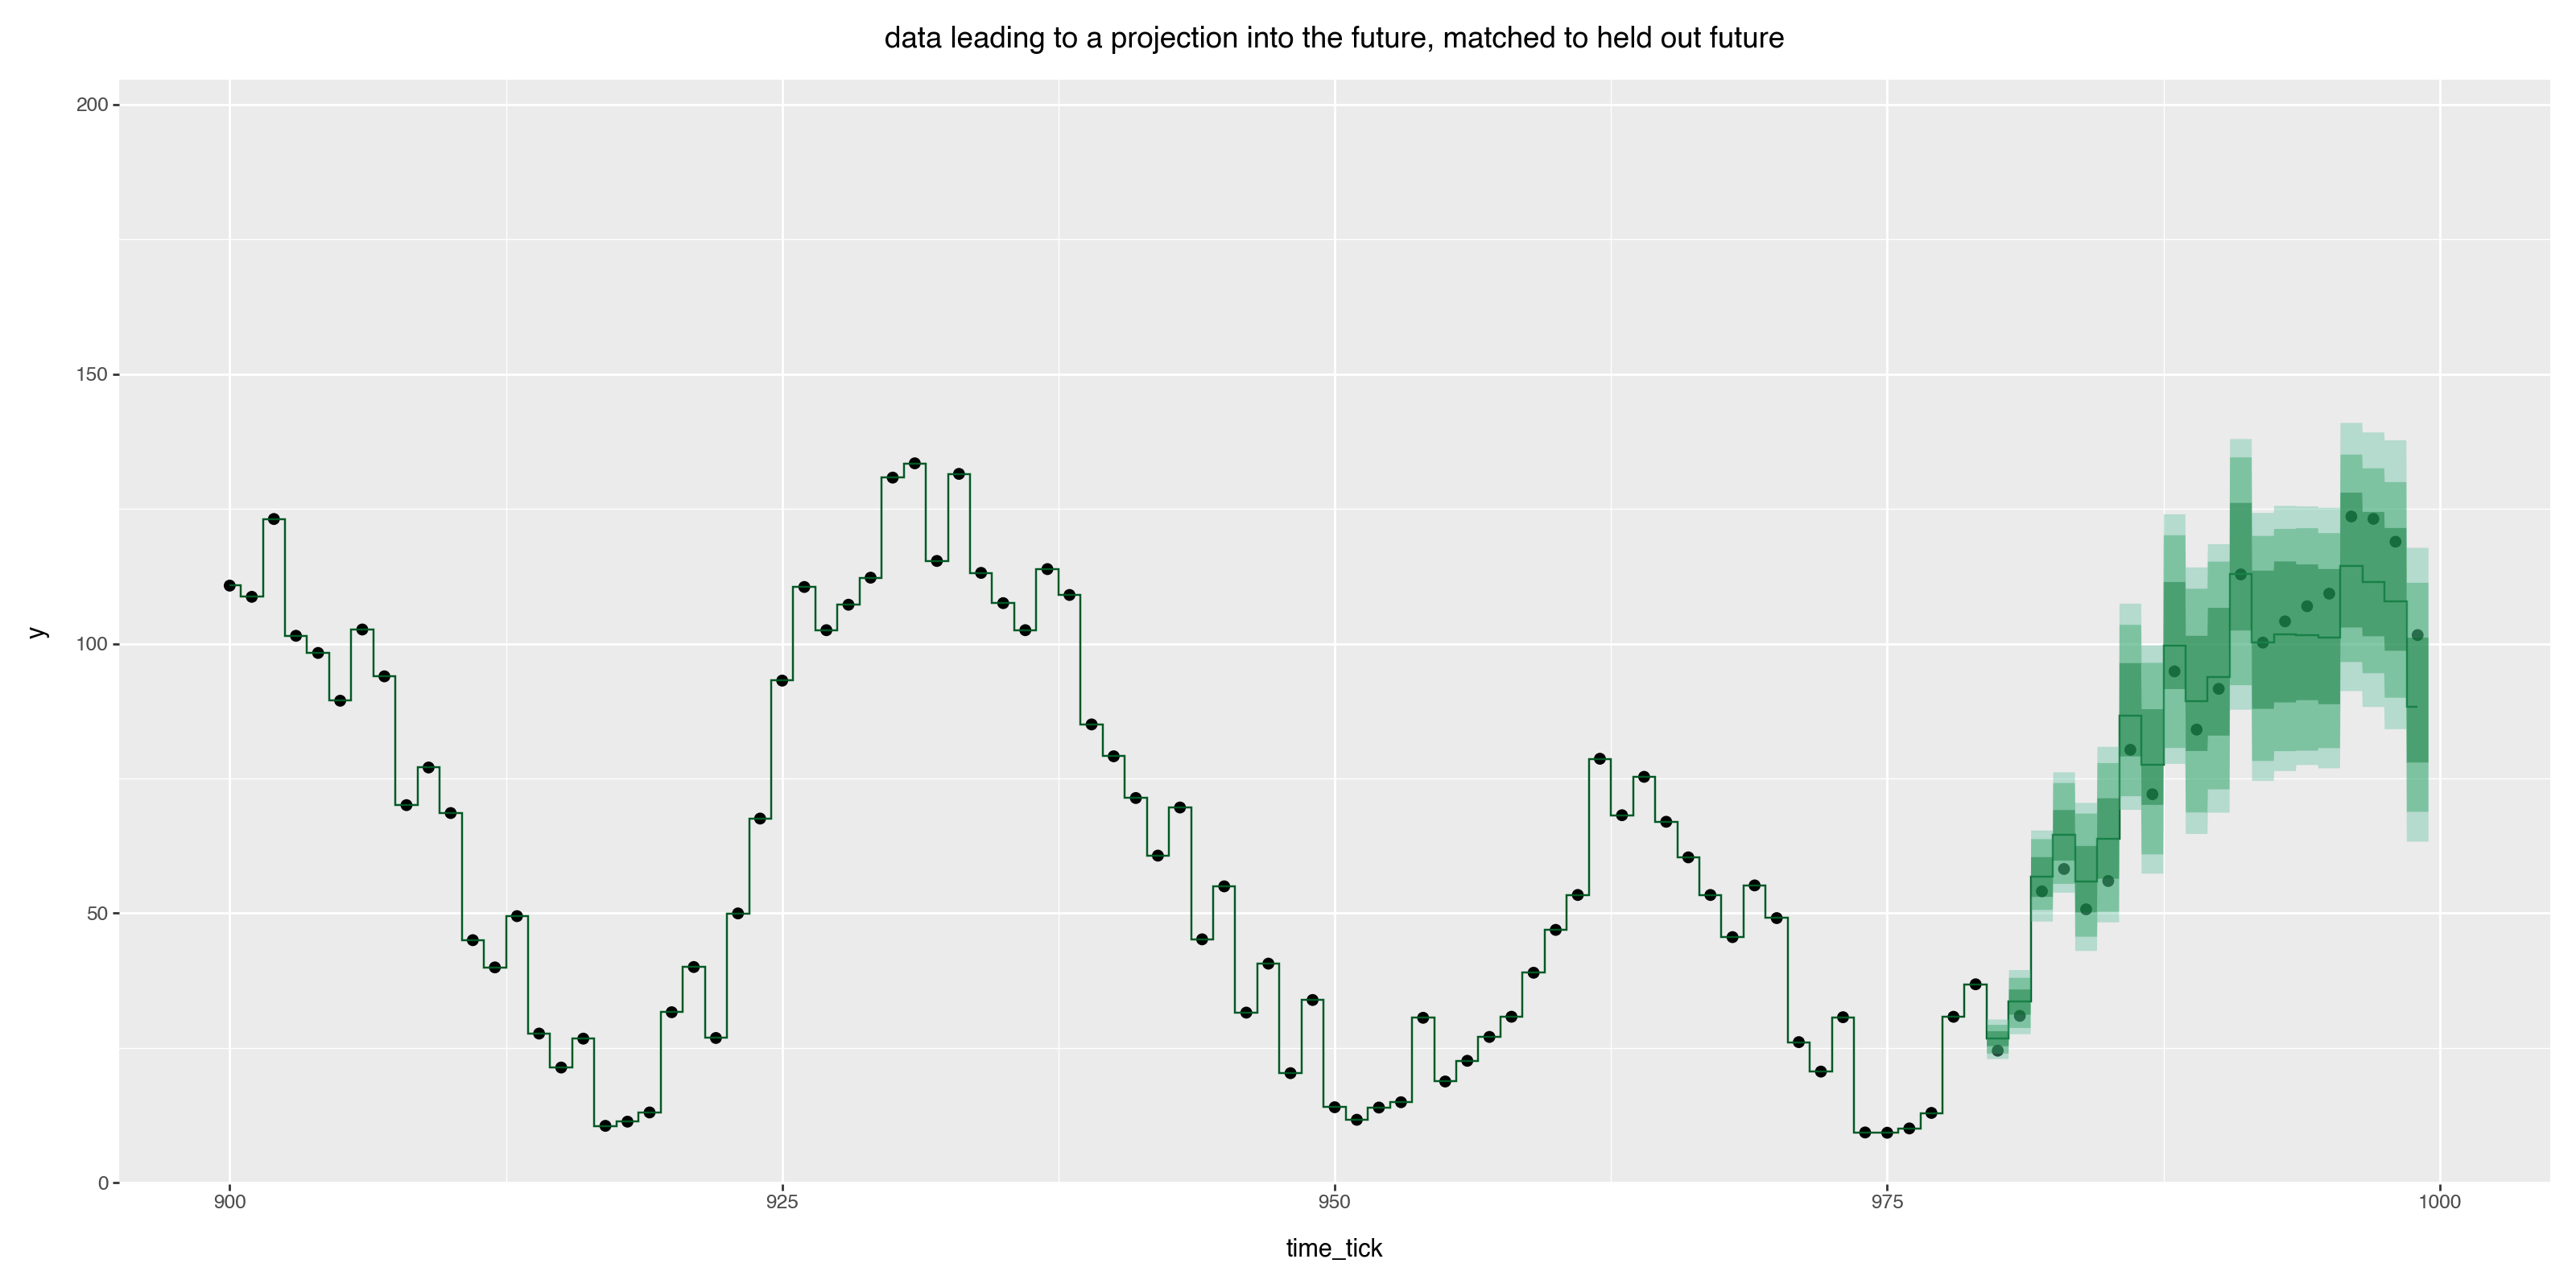

In [16]:
display(p2)

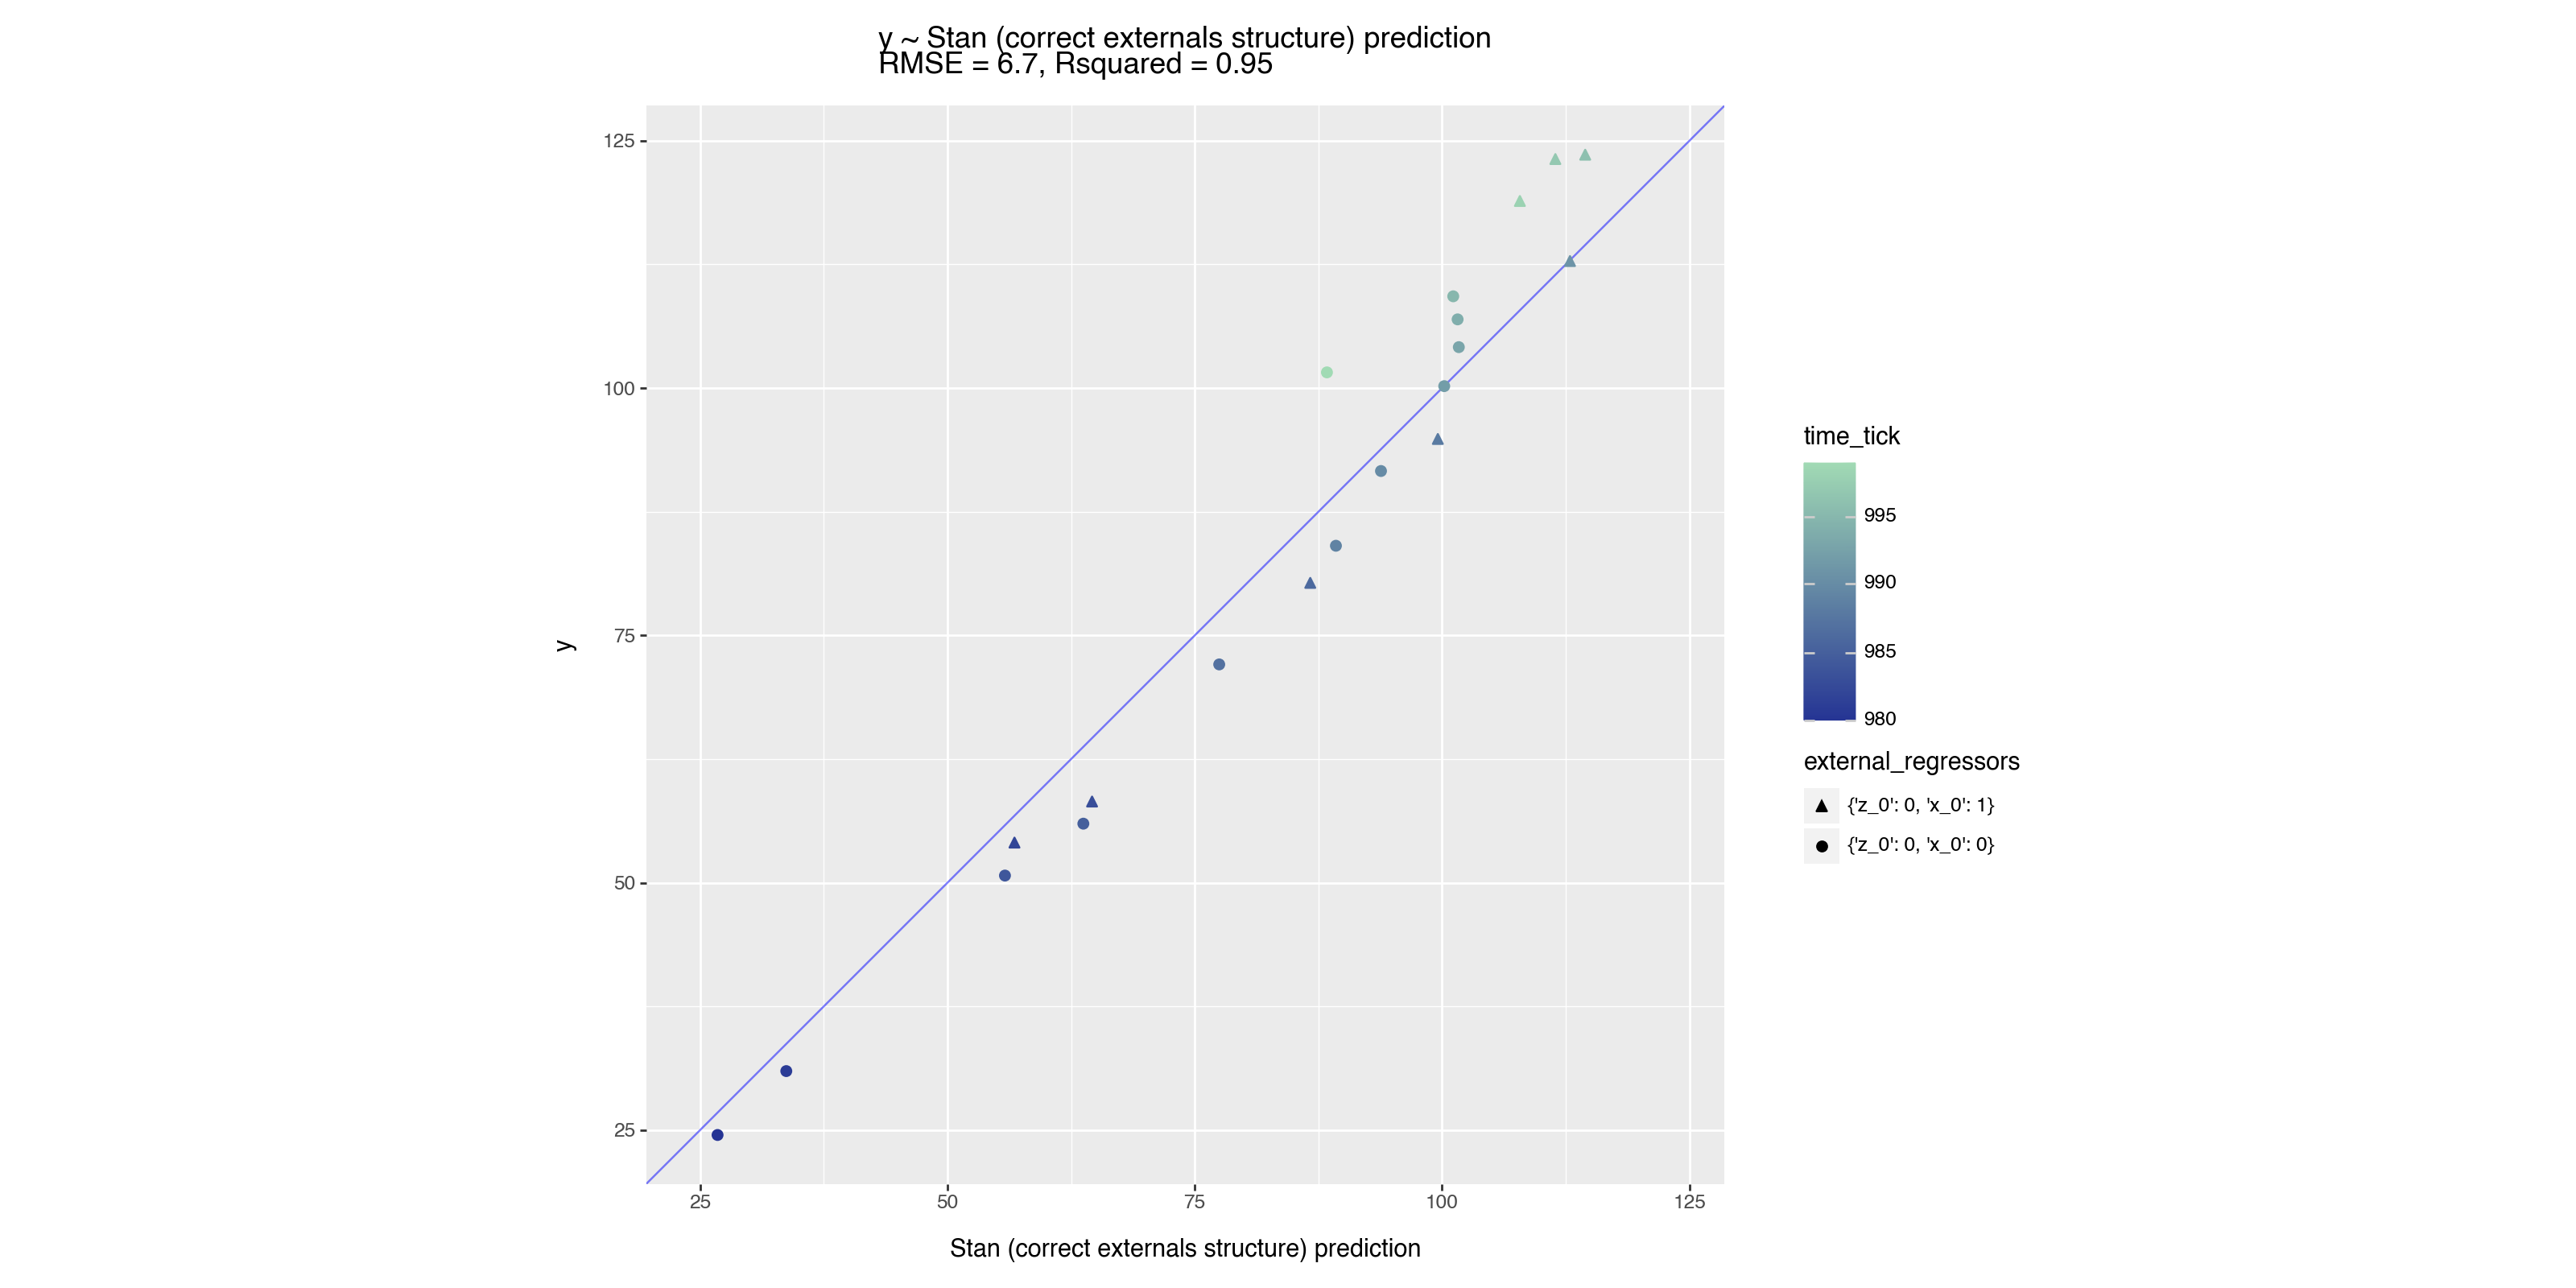

In [17]:
# plot quality of fit as a scatter plot
d_test["Stan (correct externals structure) prediction"] = extract_sframe_result(
    s_frame_i
)
plot_model_quality(
    d_test=d_test,
    result_name="Stan (correct externals structure) prediction",
    external_regressors=["z_0", "x_0"],
)

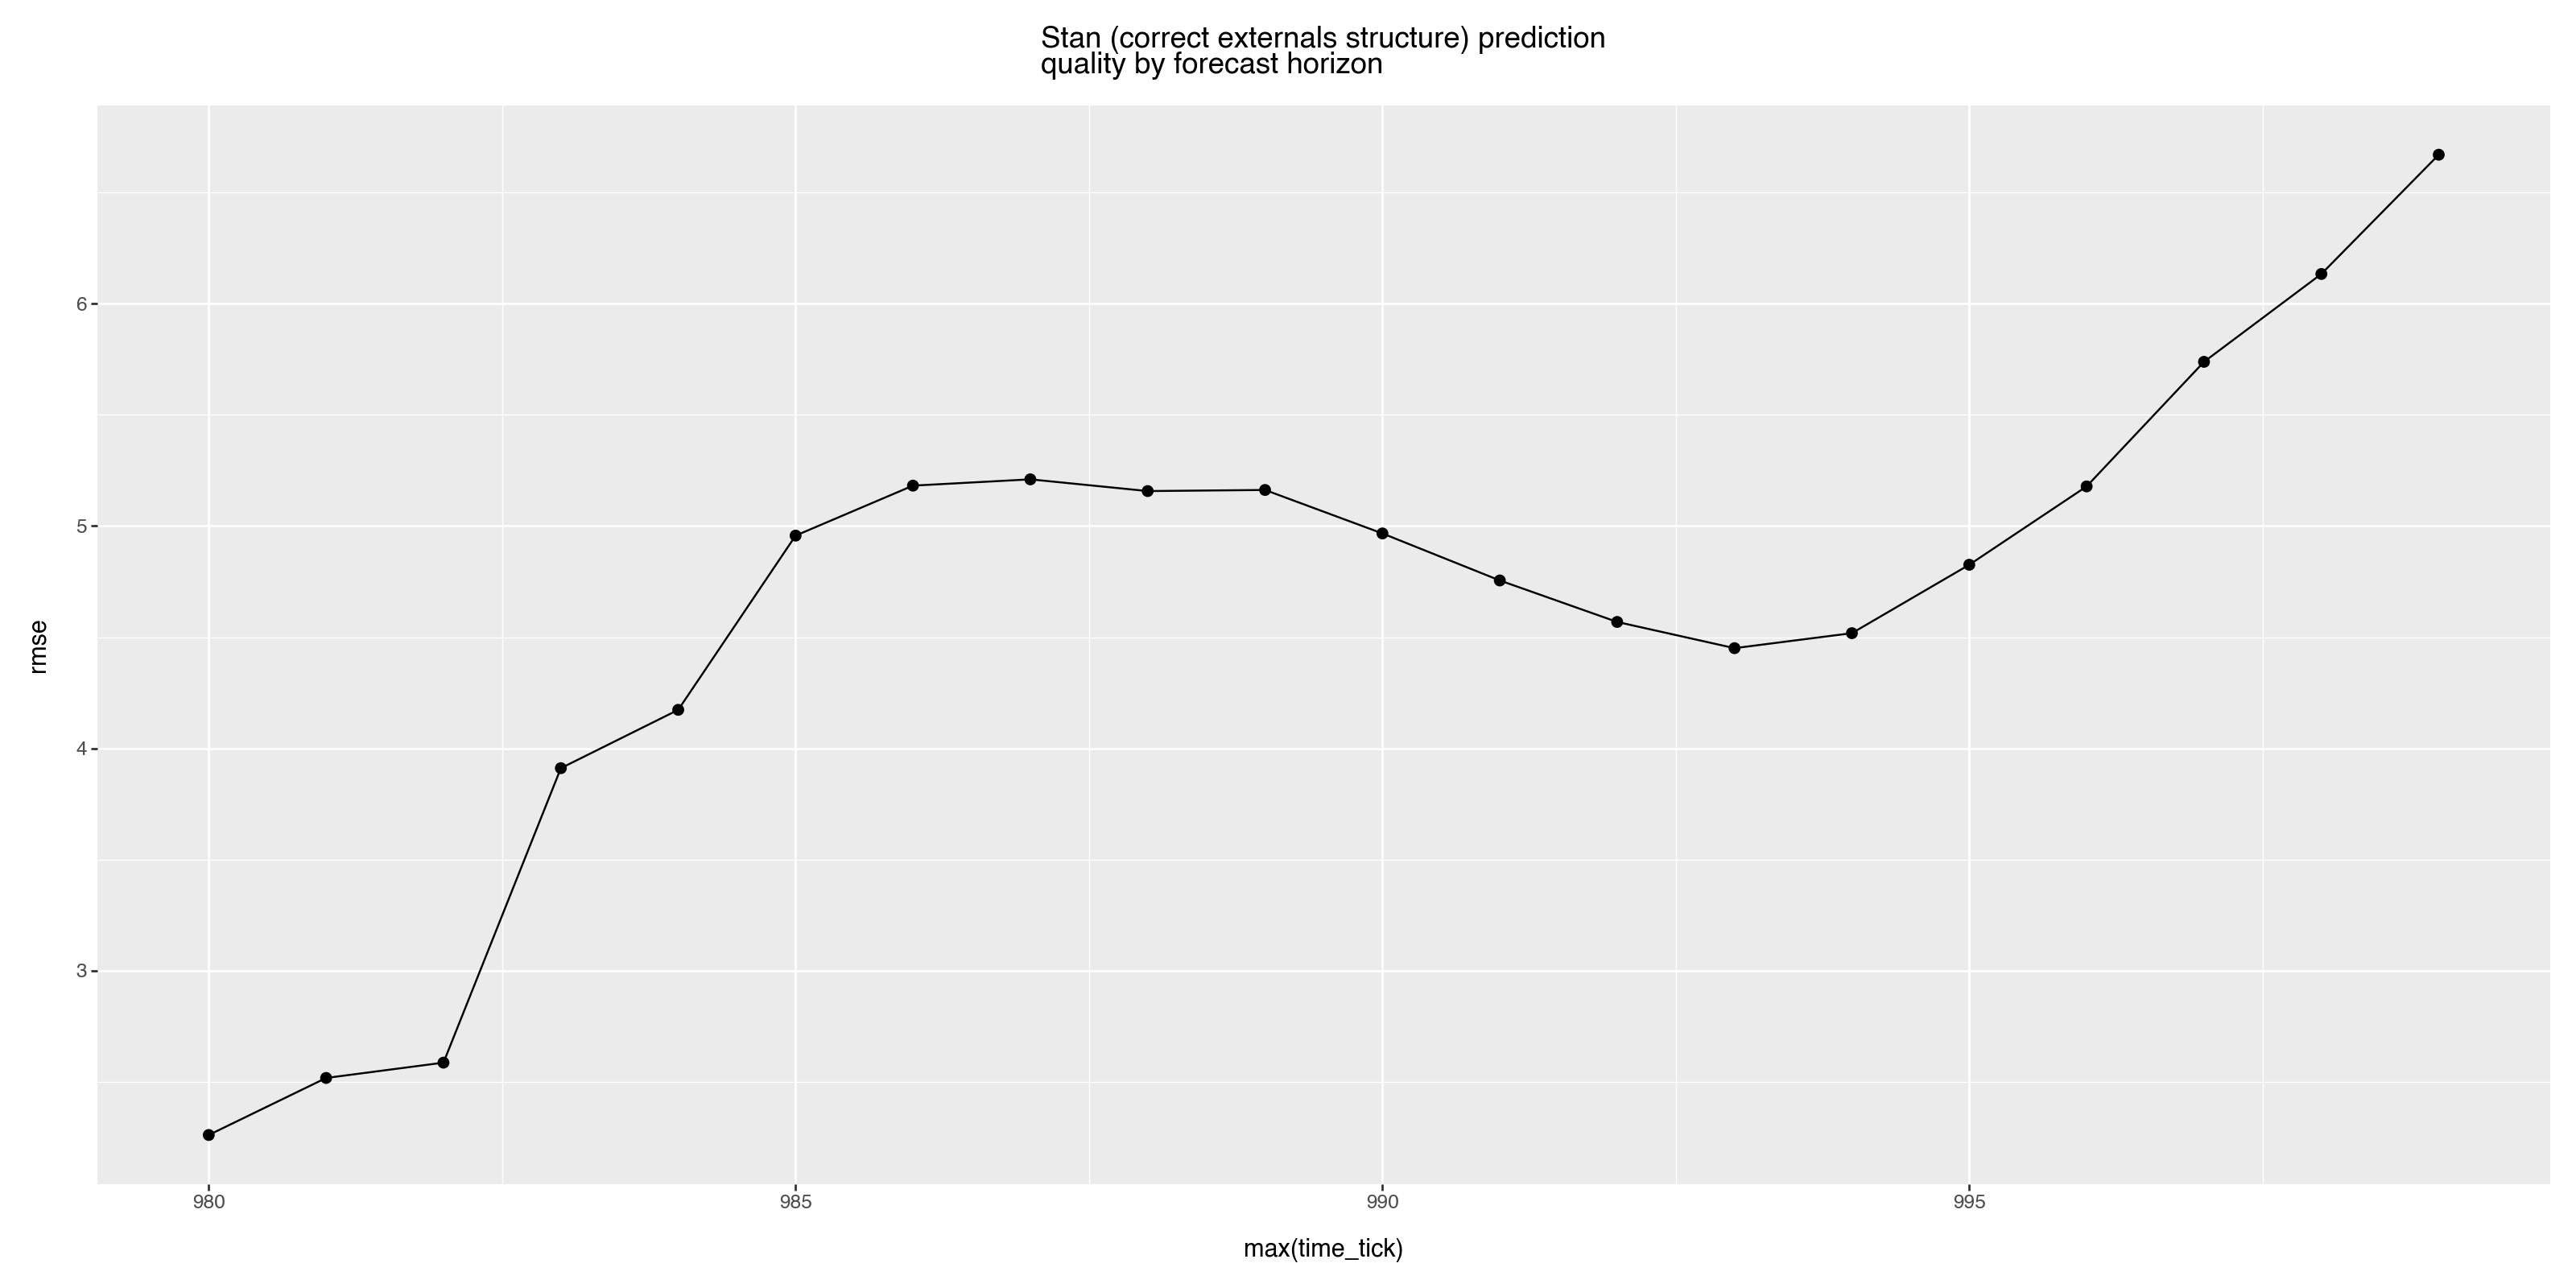

In [18]:
# plot quality as a function of how far out we are predicting
plot_model_quality_by_prefix(
    s_frame=s_frame_i,
    d_test=d_test,
    result_name="Stan (correct externals structure) prediction",
)

The model identifies 3 very valuable things:

  * Estimates of the model parameters: 
     * `b_auto_0`
     * `b_auto[0]`
     * `b_auto[1]`
     * `b_x_dur[0]`
     * `b_x_imp[0]`
  * Projections or applications of the model for future `time_tick`s 950 through 999.
  * Good inferences of the most recent unobserved states `y_auto[948]` and `y_auto[949]` in the training period.

The third item provides a much more useful estimate of then hidden state (based on evaluation of trajectories through the entire training period) than the simple single point estimate `y_auto[i] ~ y[i] * b_x_impl[0] - x_0[i]`. One can evolve estimates forward from these inferences, and that is not always the case for the simple expected value estimates.

The issue with the simple (or naive) estimates being: they are single value point estimates, not necessarily compatible with *any* of the estimate sampling trajectories. Plugging in the naive estimates often does not allow one to evolve the prediction trajectories forward in a sensible manner. The detailed estimates from the Stan sampler do allow such forward evolution of estimates (either inside the Stan sampler as shown, or as a simple external procedure).


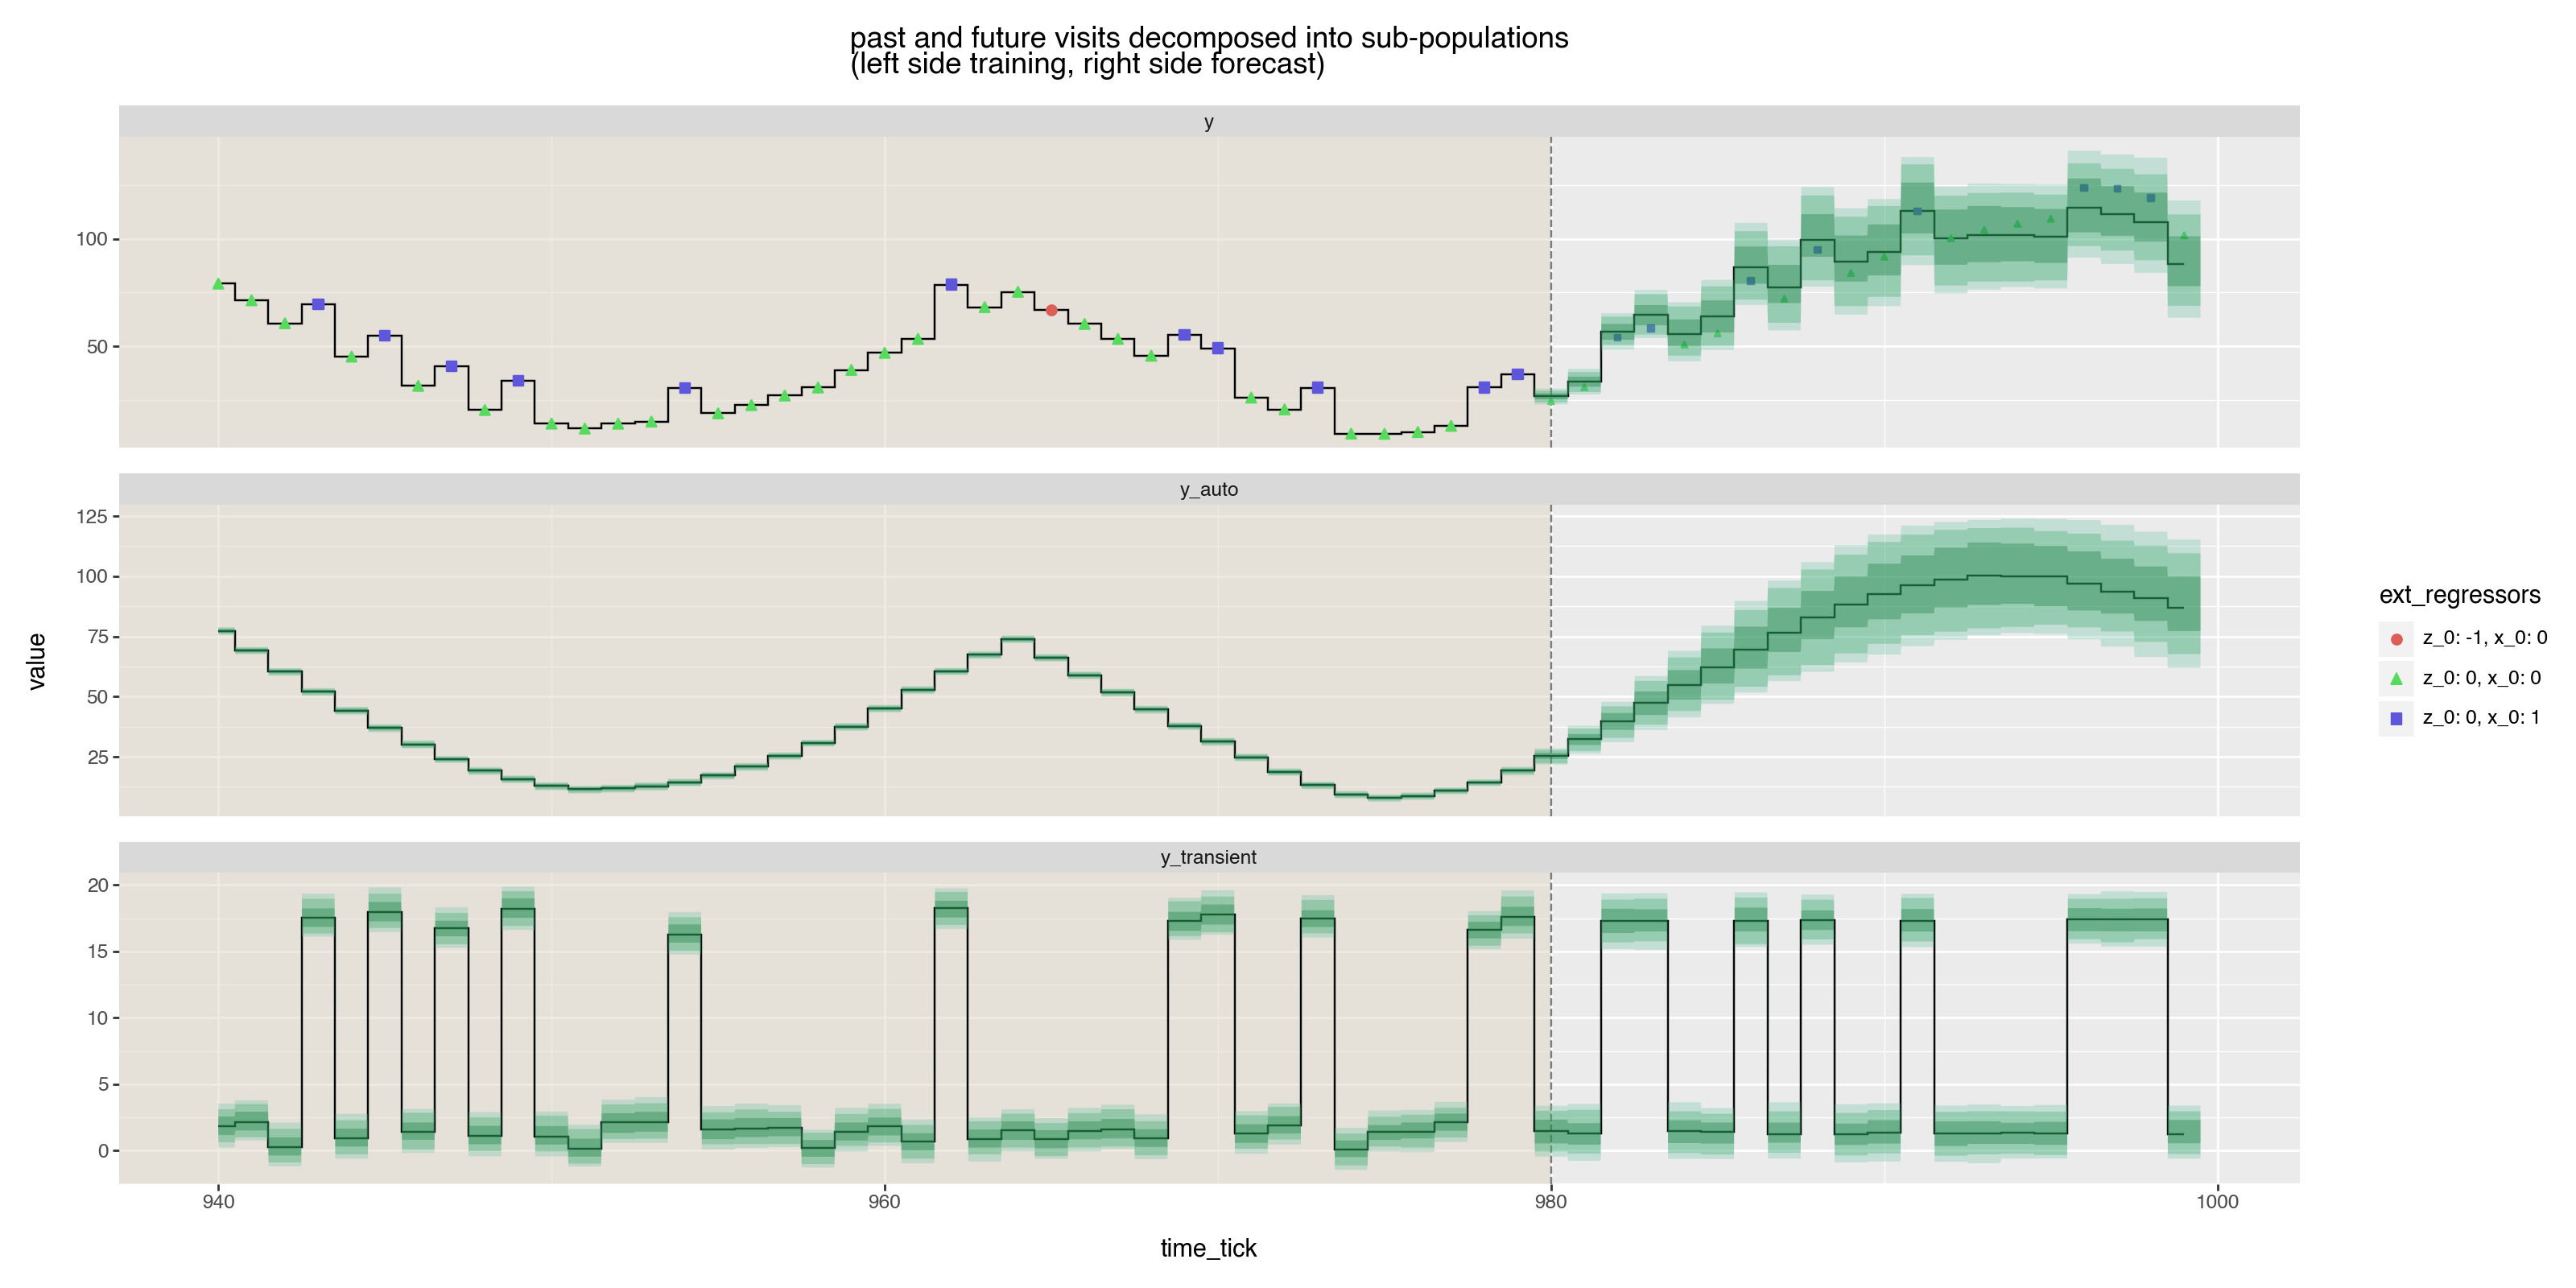

In [19]:
plot_decomposition(
    forecast_soln_i=forecast_soln_i,
    d_train=d_train,
    d_test=d_test,
)

The calling sequence to do this in Stan from Python is as follows. One can also call Stan from the command line or from R.

In [20]:
display(Markdown(f"```python\n{inspect.getsource(solve_forecast_by_Stan)}\n```"))

```python
def solve_forecast_by_Stan(
    model,
    *,
    d_train: pd.DataFrame,
    d_apply: pd.DataFrame,
    transient_external_regressors: Optional[Iterable[str]] = None,
    durable_external_regressors: Optional[Iterable[str]] = None,
) -> pd.DataFrame:
    """
    Fit a forecast through d_train, and then apply the forecast in the d_apply region (d_apply doesn't need y value).
    """
    # specify data file
    data_file = "nested_model_tmp.data.json"
    # write data
    write_Stan_data(
        d_train=d_train,
        d_apply=d_apply,
        transient_external_regressors=transient_external_regressors,
        durable_external_regressors=durable_external_regressors,
        data_file=data_file,
    )
    # fit the model and draw observations
    # https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample
    # https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.optimize
    fit = model.sample(
        data=data_file,
        # iter_warmup=8000,
        # iter_sampling=8000,
        # adapt_engaged=True,
        show_progress=False,
        show_console=False,
    )
    # get the samples
    res = fit.draws_pd()
    # re-number from zero
    res = res.rename(
        columns={
            k: _replace_k_with_k_minus_1(k)
            for k in res.columns
            if ("[" in k) and (not k.endswith("__")) and (not k.startswith("__"))
        },
        inplace=False,
    )
    return res

```

## Bayesian method without external regressors


Let's get back to overall methodology.

As a lower-bound on model quality we can try a Bayesian (Stan) model without external regressors.


In [21]:
# define a Stan model without external predictors
stan_model_with_forecast_0, stan_model_with_forecast_src_0 = (
    define_Stan_model_with_forecast_period(
        application_lags=modeling_lags,
        n_transient_external_regressors=0,
        n_durable_external_regressors=0,
    )
)

In [22]:
# show the model specification
print(stan_model_with_forecast_src_0)


data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector<lower=0>[N_y_observed] y_observed;   // observed outcomes
}
parameters {
  real b_auto_0;                      // auto-regress intercept
  real b_imp_0;                       // total/impulse/transient intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector<lower=0>[N_y_future] y_future;                // to be inferred future state
  vector<lower=0>[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (durable) noise variance
  real<lower=0> b_var_y;                      // presumed y (transient) noise variance
}
transformed parameters {
        // y_observed and y_future in one notation (for subscripting)
  vector[N_y_observed + N_y_future] y;        
  y[1:N_y_observed] = y_observed;
 

In [23]:
# sample from Stan model solutions
forecast_soln_0 = solve_forecast_by_Stan(
    model=stan_model_with_forecast_0,
    d_train=d_train,
    d_apply=d_test,
)

In [24]:
# summarize parameter estimates
forecast_soln_0.loc[:, [c for c in forecast_soln_0 if c.startswith("b_")]].median()

b_auto_0        1.989285
b_imp_0         1.898715
b_auto[0]       1.921800
b_auto[1]      -0.951456
b_var_y_auto    2.020980
b_var_y         7.733425
dtype: float64

In [25]:
# show original generative parameters
generating_params

{'b_auto_0': 1.2804125781056719,
 'b_imp_0': 10.4,
 'b_auto': [1.9753766811902755, -1],
 'b_z': [14.2],
 'b_x': [16.1],
 'generating_lags': [1, 2],
 'modeling_lags': [1, 2]}

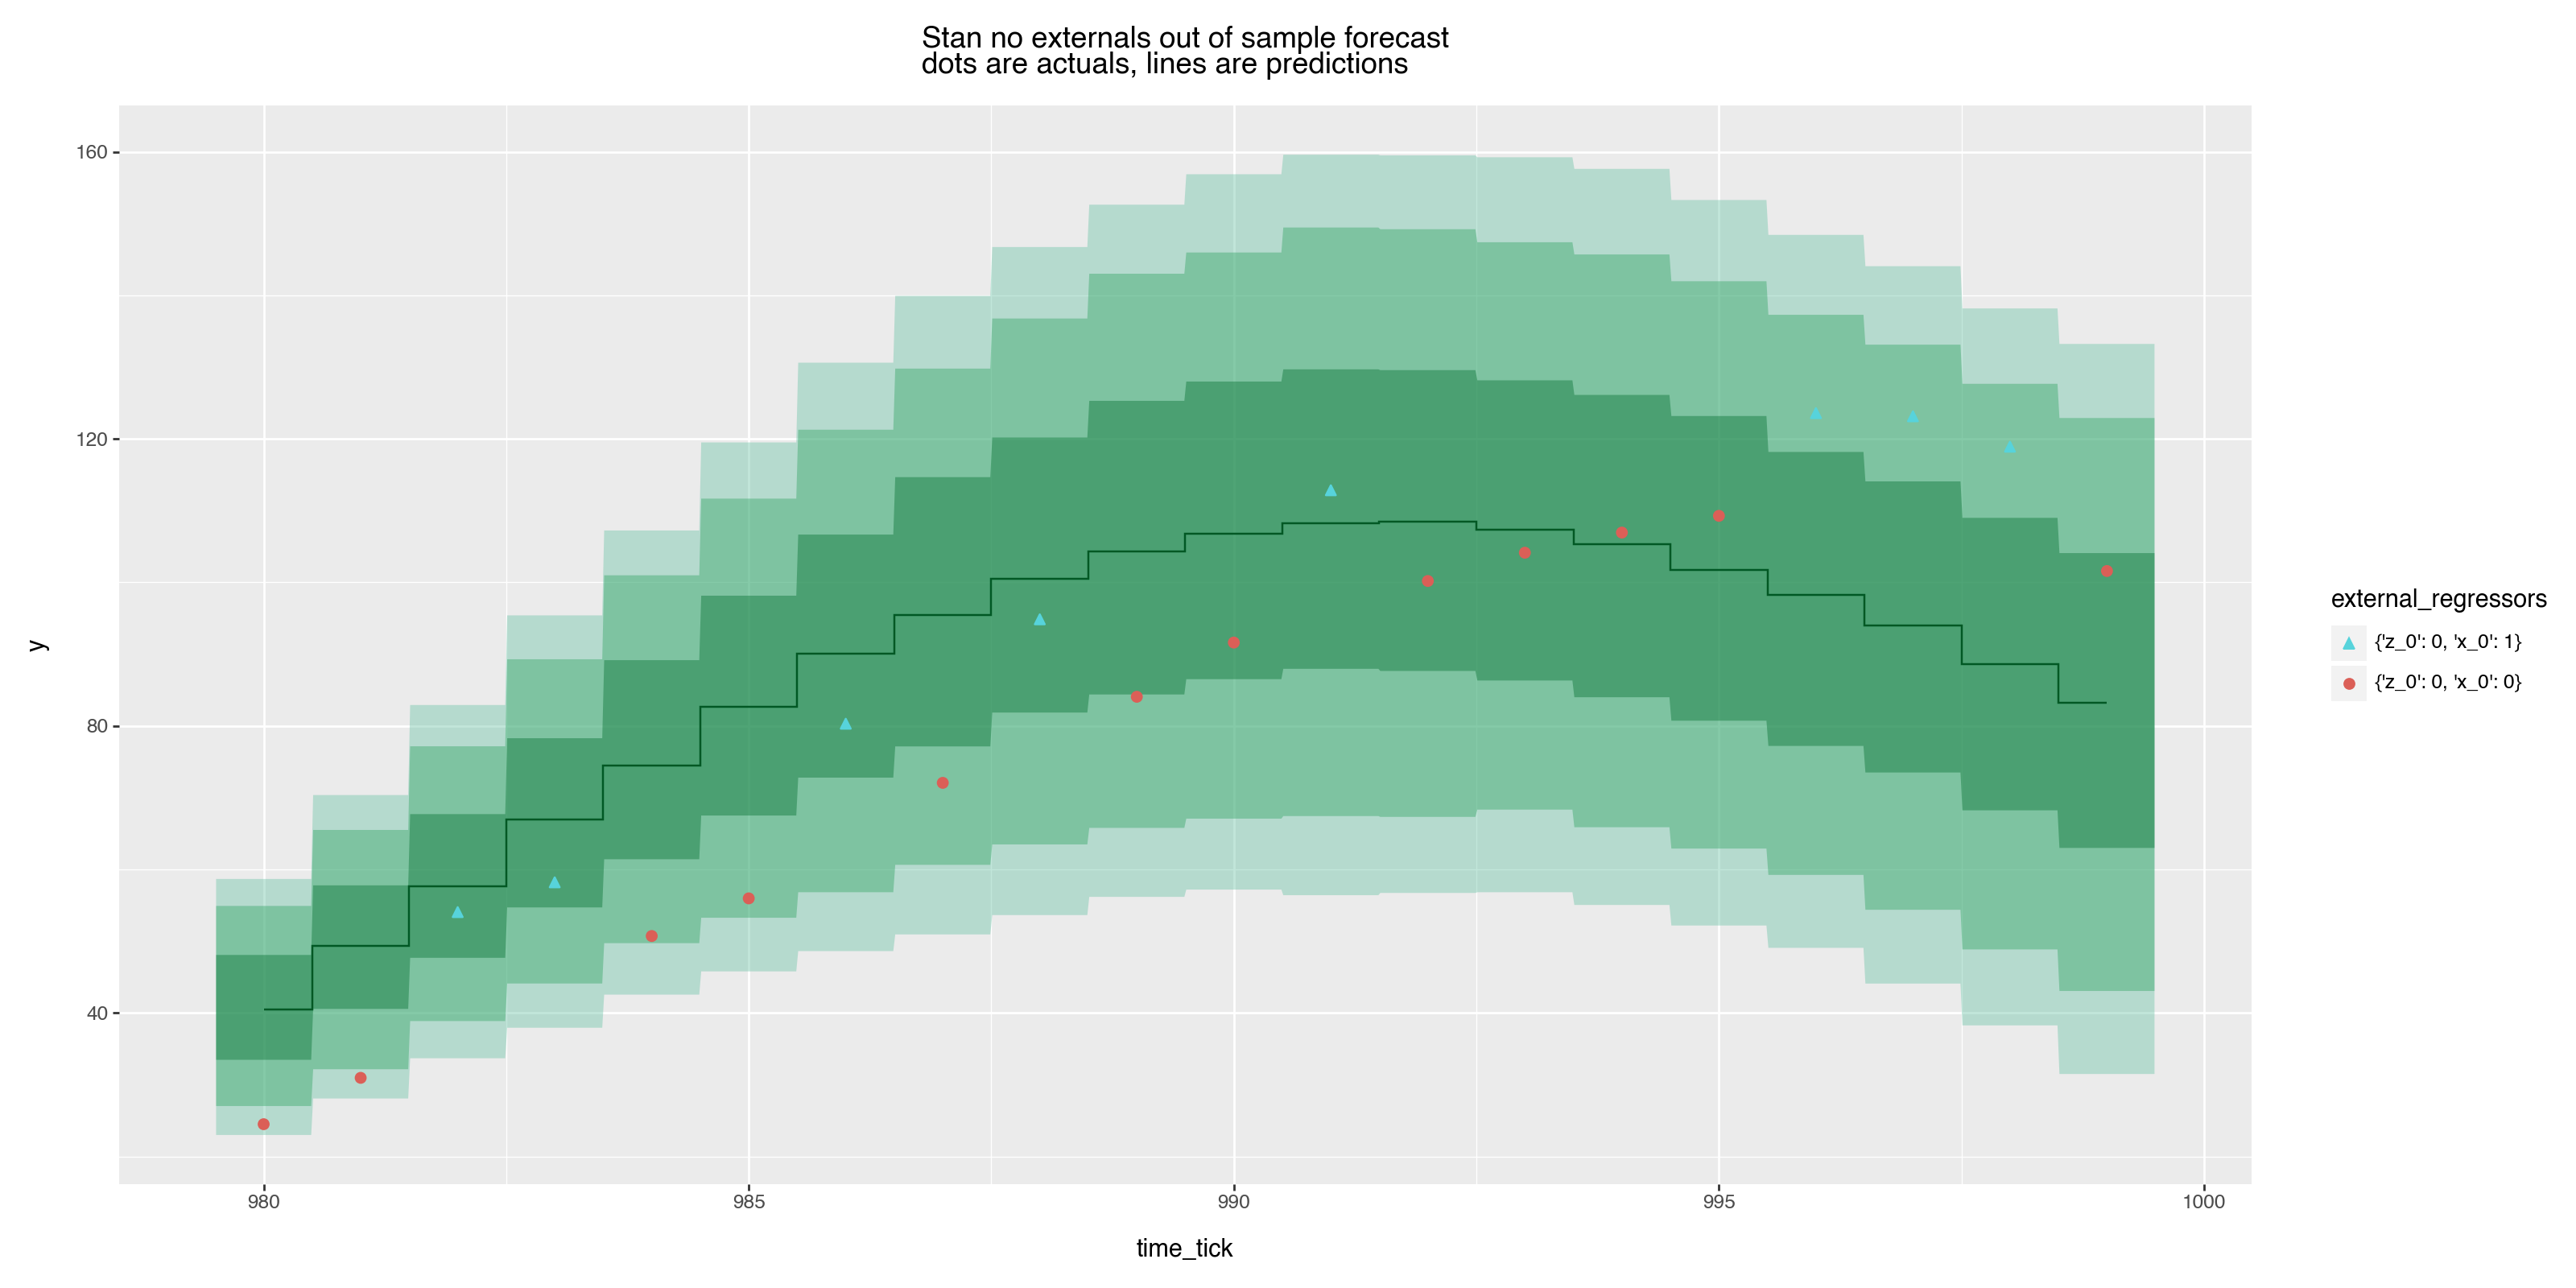

In [26]:
# plot fit over time
plt_0, s_frame_0 = plot_forecast(
    forecast_soln_0,
    d_test,
    model_name="Stan no externals",
    external_regressors=["z_0", "x_0"],
)
plt_0.show()

Notice both the predictions are "middle of the road" estimates again.


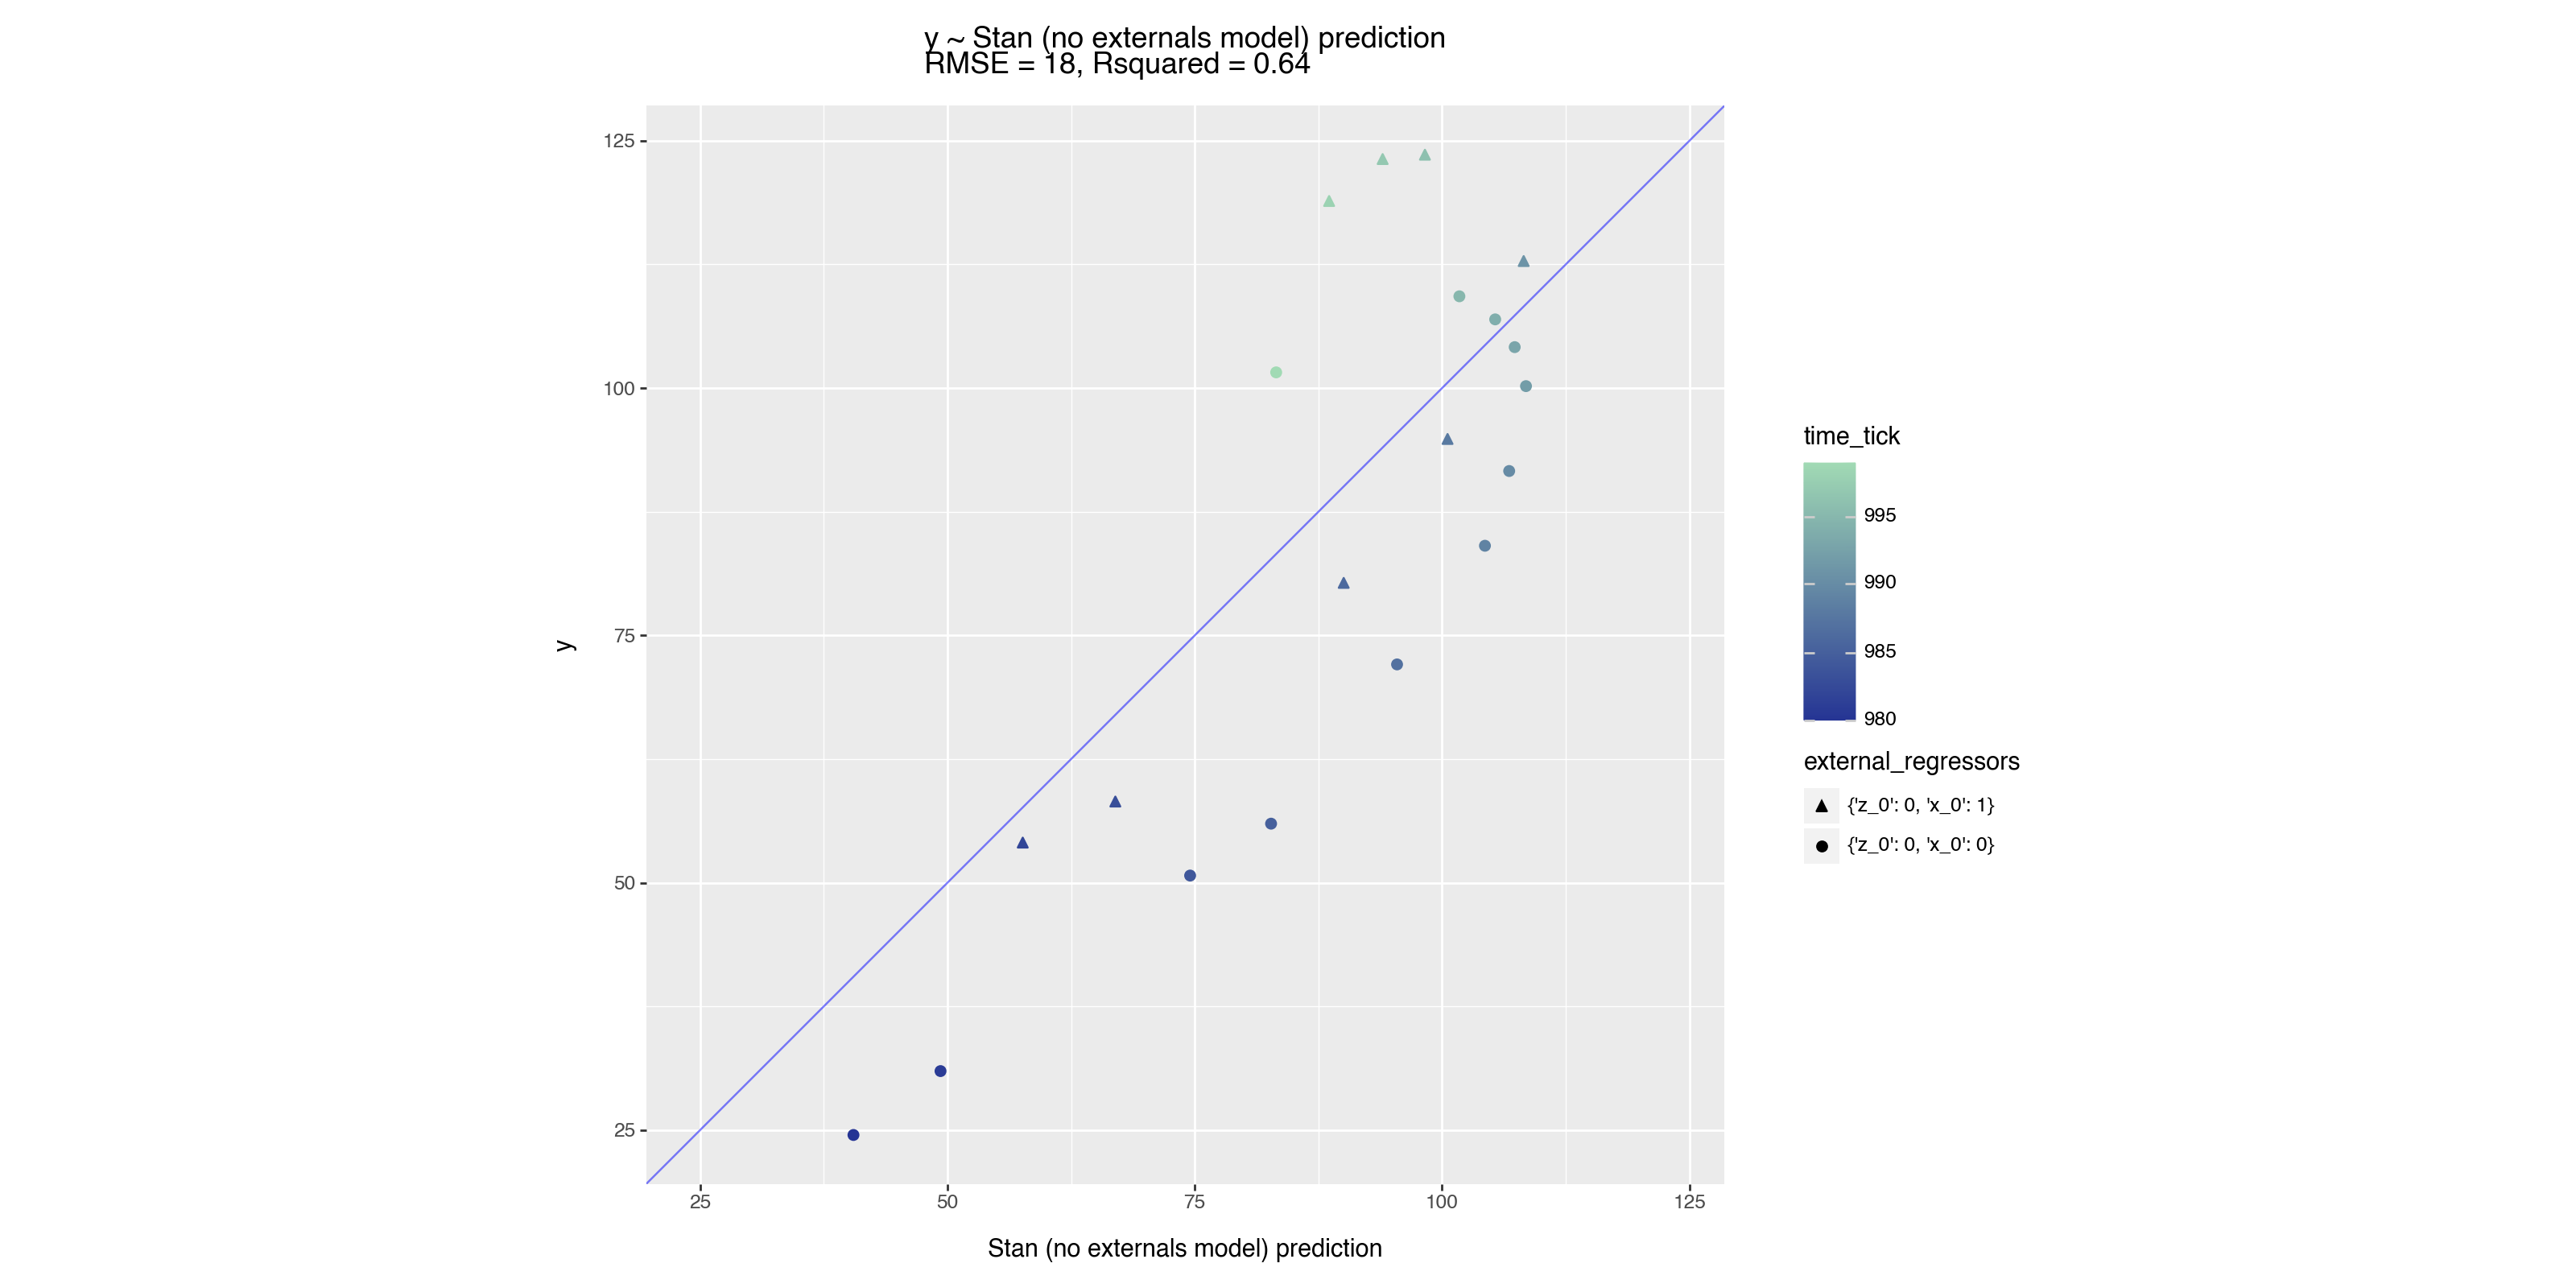

In [27]:
# plot quality of fit as a scatter plot
d_test["Stan (no externals model) prediction"] = extract_sframe_result(s_frame_0)
plot_model_quality(
    d_test=d_test,
    result_name="Stan (no externals model) prediction",
    external_regressors=["z_0", "x_0"],
)

## Conclusion


And that concludes our note on modeling in the presence of external regressors. The main point is: one has to specify the structure of the regressors. Do they cause durable effects (such as marketing efforts) or do they cause transient effects (such as one-off sales events)? Also: we would like such specifications to be in terms familiar to domain experts, and not deep in ARMAX or transfer function terminology.
